In [1]:
import  pandas as pd 

import sys 
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import shap

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the cleaned DataFrame saved in data_cleaning module
%store -r df_train_cleaned

print(df_train_cleaned)

     MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave    NA      Reg   
1            20       RL         80.0     9600   Pave    NA      Reg   
2            60       RL         68.0    11250   Pave    NA      IR1   
3            70       RL         60.0     9550   Pave    NA      IR1   
4            60       RL         84.0    14260   Pave    NA      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
1455         60       RL         62.0     7917   Pave    NA      Reg   
1456         20       RL         85.0    13175   Pave    NA      Reg   
1457         70       RL         66.0     9042   Pave    NA      Reg   
1458         20       RL         68.0     9717   Pave    NA      Reg   
1459         20       RL         75.0     9937   Pave    NA      Reg   

     LandContour Utilities LotConfig  ... MiscFeature MiscVal MoSold YrSold  \
0            Lvl    AllPub    Inside  ...          NA   

### Analyse the distribution of numeric features

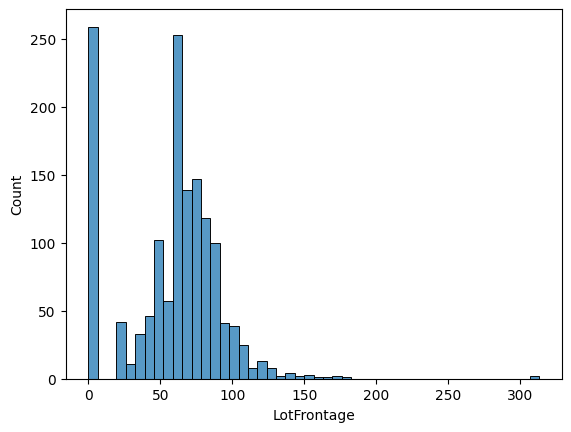

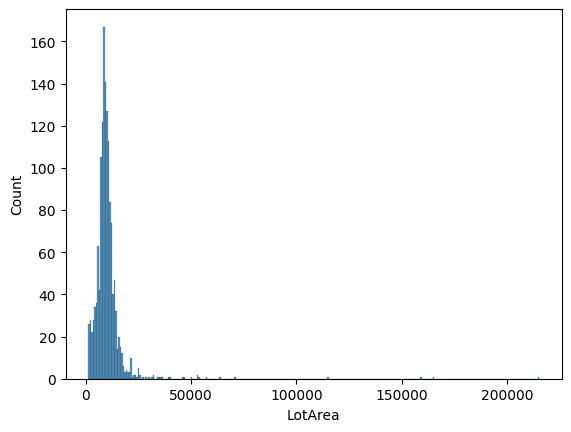

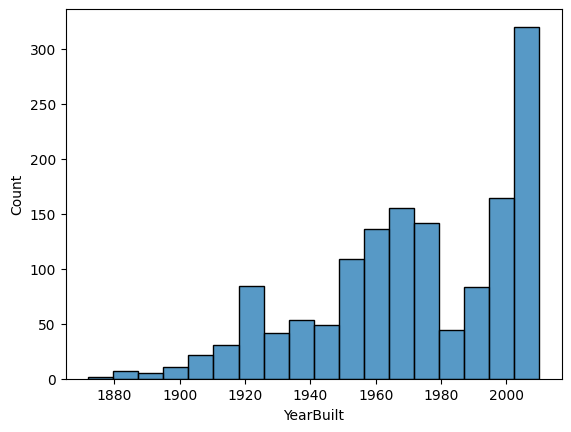

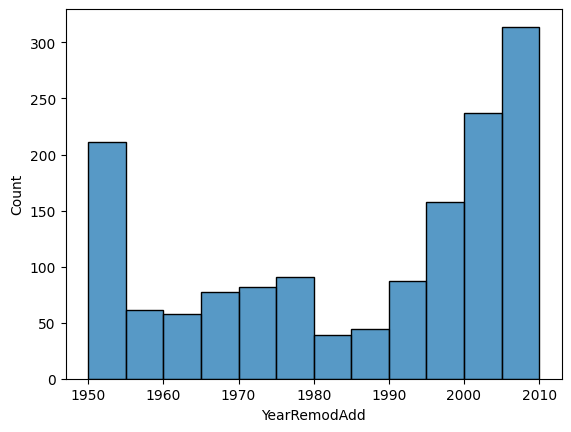

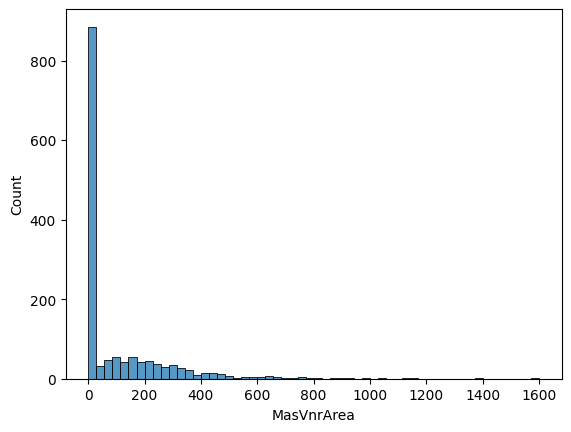

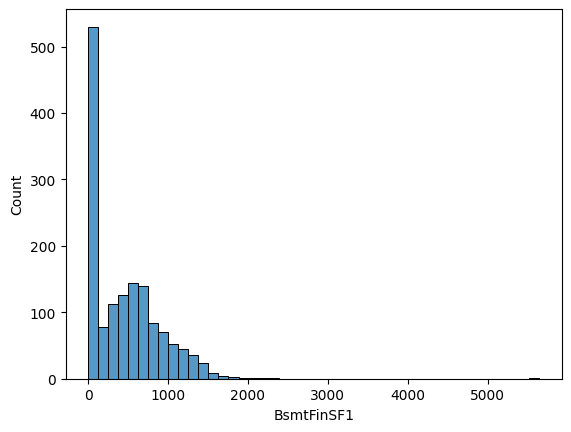

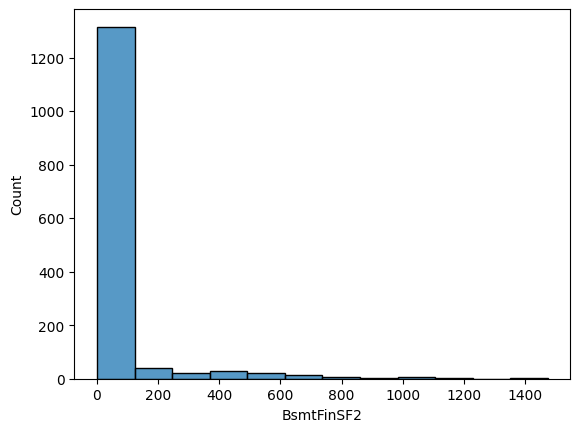

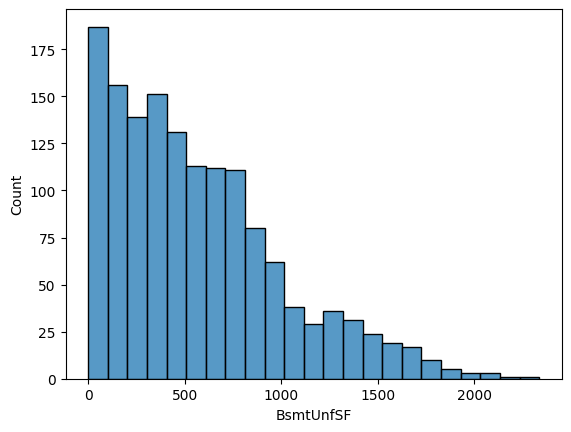

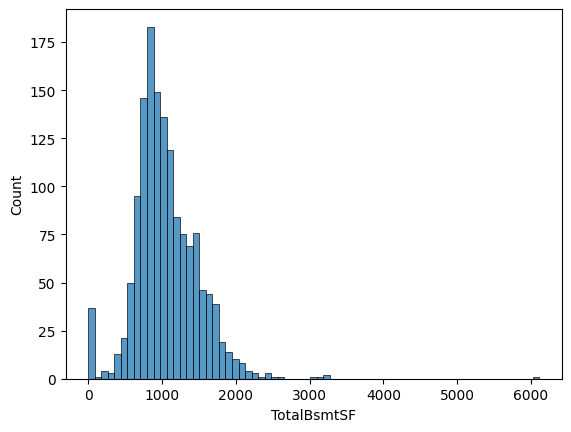

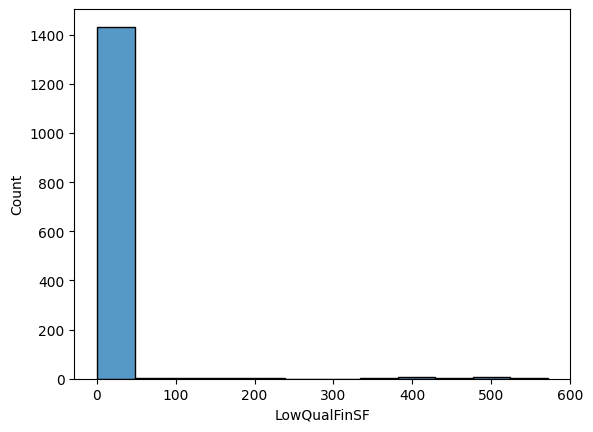

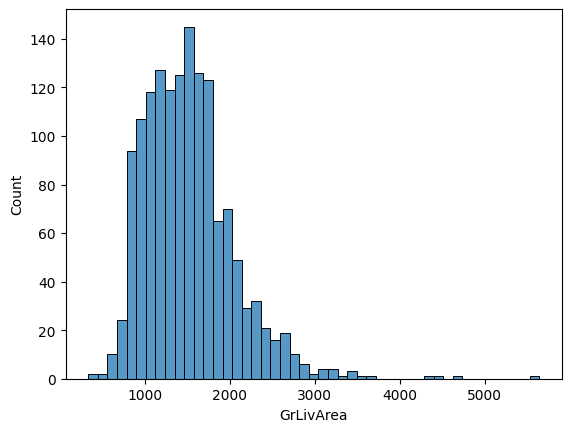

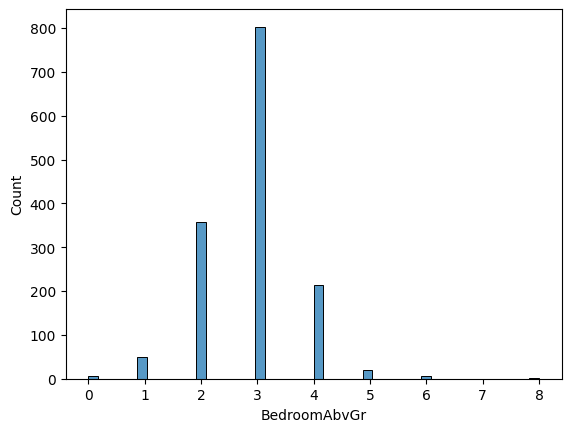

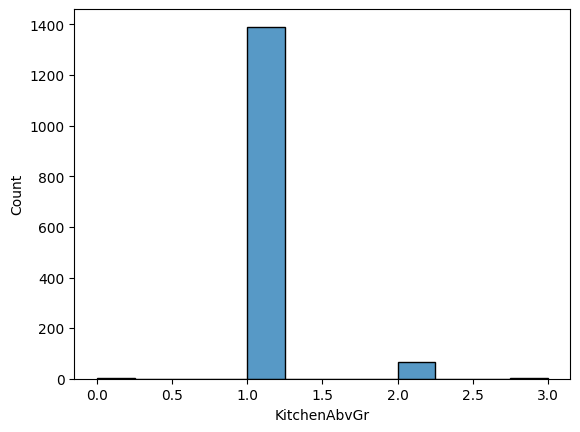

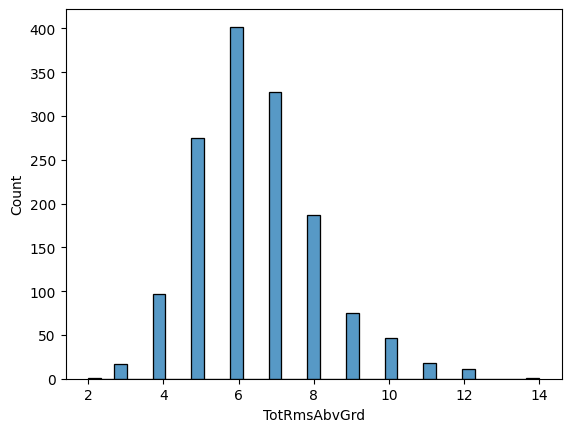

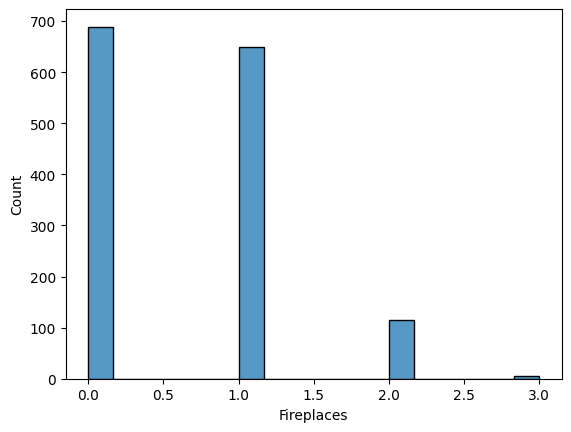

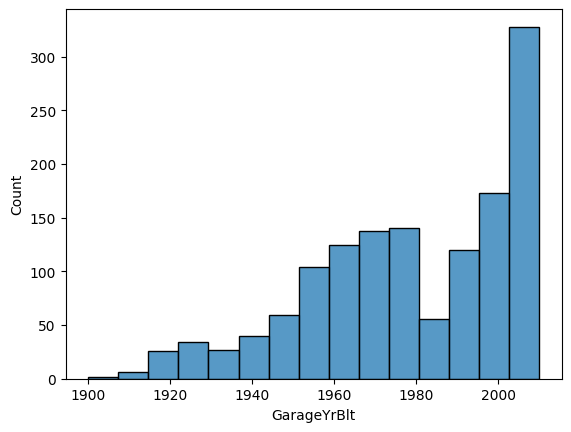

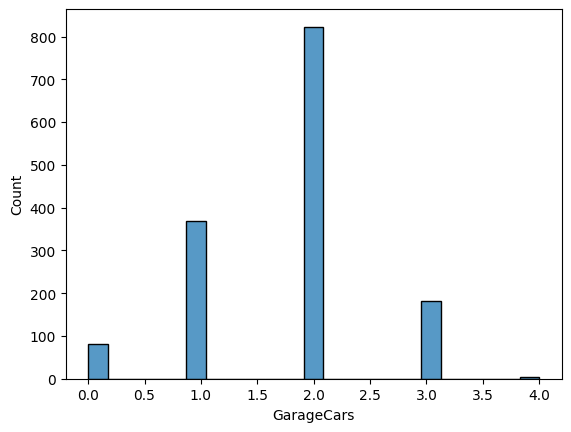

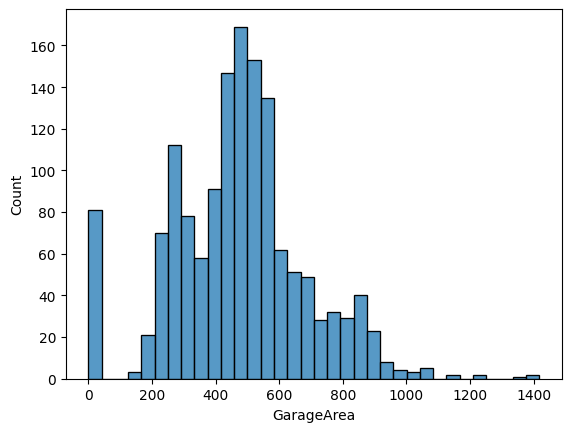

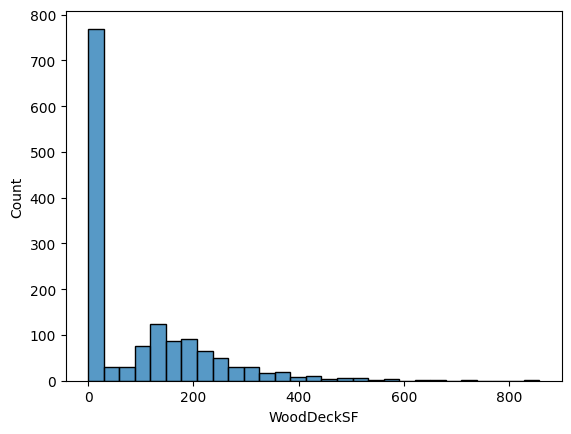

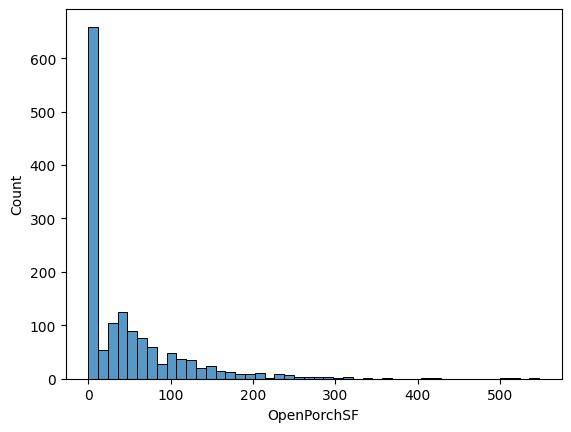

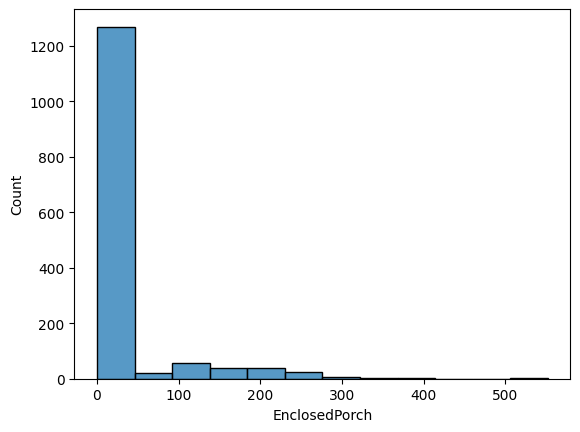

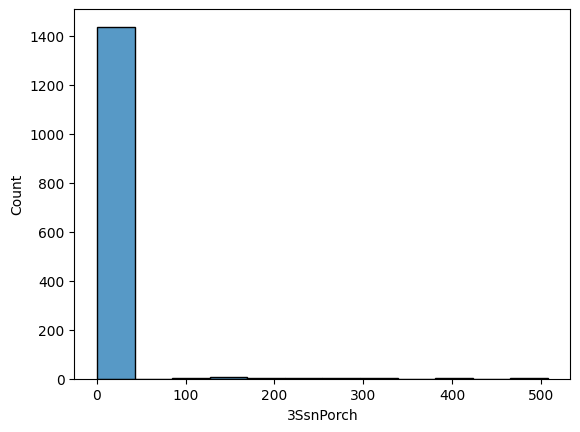

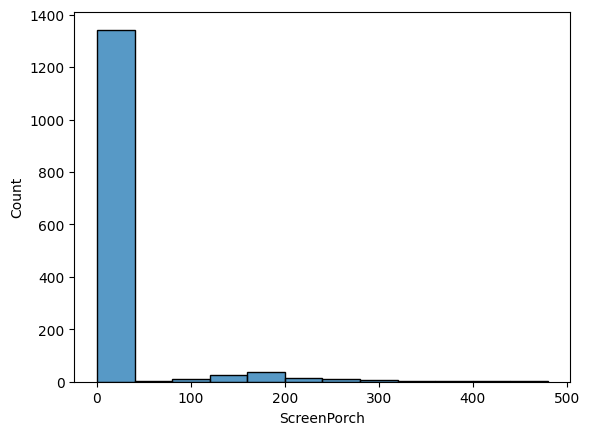

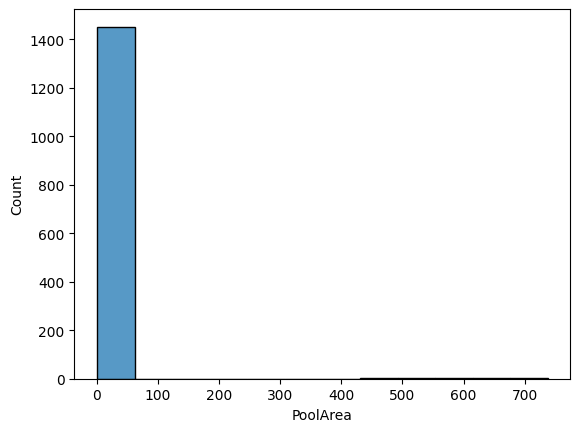

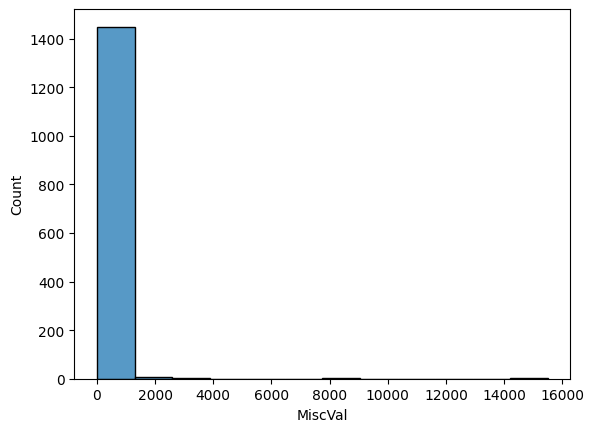

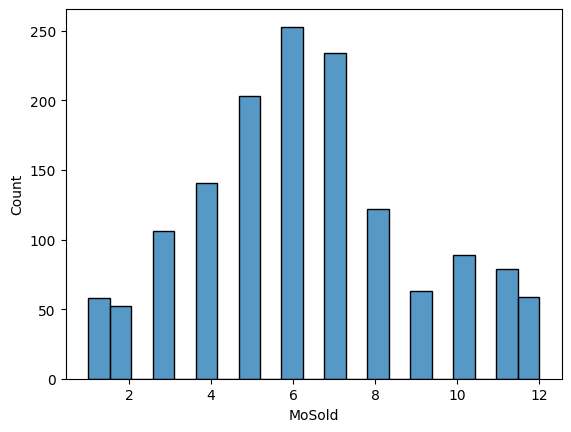

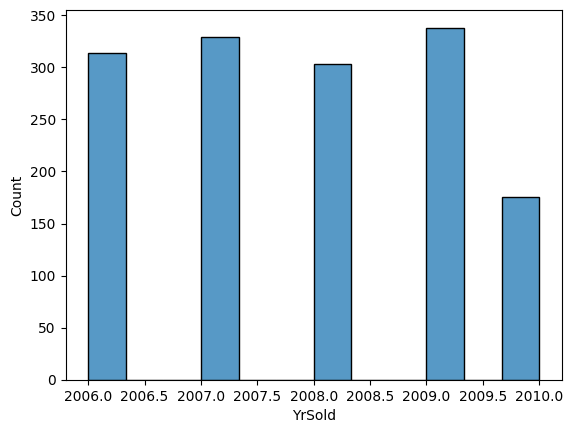

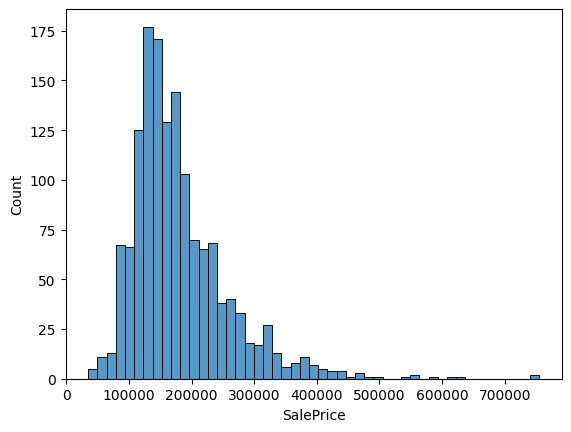

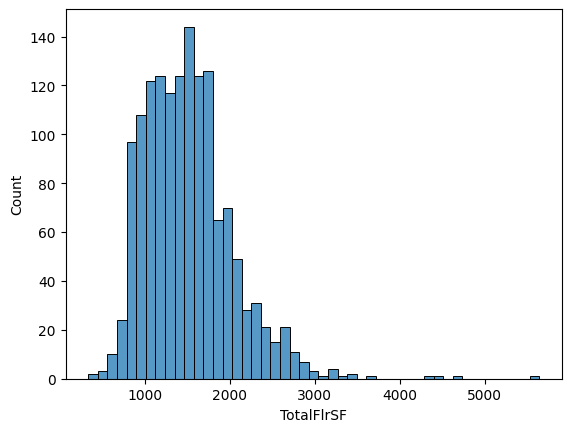

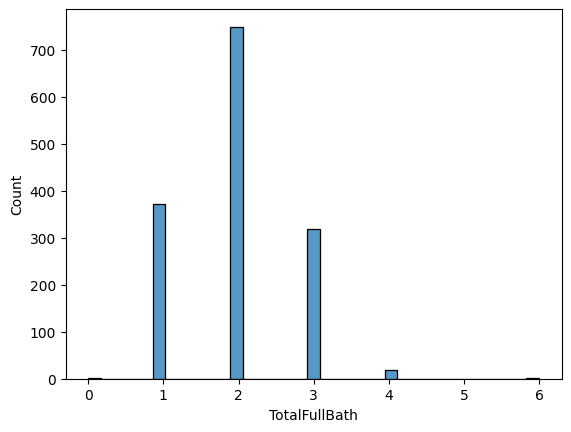

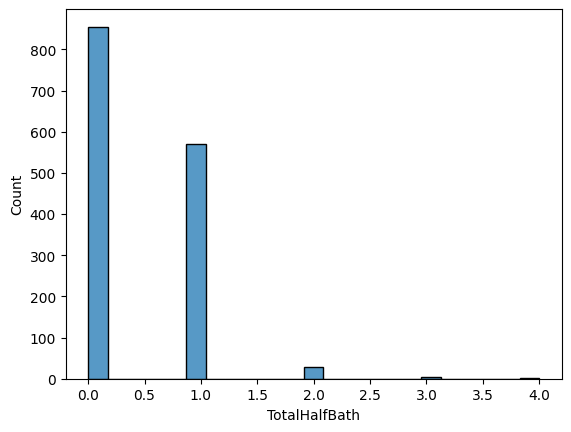

In [3]:
for clmn in df_train_cleaned.select_dtypes(include=np.number).columns:
    sns.histplot(df_train_cleaned, x=clmn)
    plt.show()

1. Many data with "LotFrontage" almost zero, the rest is like normal distribution with an extreme
2. "LotArea" - normal distribution right-skewed
3. "MassVnrArea" - many almost zero data, the rest is normal distribution right-skewed
4. "BsmtFinSF1" - many almost zero data, the rest is normal distribution right-skewed
5. "BsmtFinSF2" - many almost zero data, the rest is normal distribution right-skewed, very low
    it may have no big impact on the price 
6. "BsmtUnfSF" - Decrease, is almost 0 after 2000 sq feet 
7. "TotalBsmtSF" - many almost zero data, the rest is normal distribution right-skewed 
8. "LowQualFinSF" - almost only zero data. Perhaps has no much impact on the target feature 
9. "GrLivArea" - normal distribution right-skewed  
9. "Bedroom" - normal distribution 
10. "Kitchen" - has only 1 peak value = 1, the rest is almost 0 
11. "TotRmsAbvGrd" - normal distribution right-skewed  
12. "Fireplaces" - Decreease 
13. "GarageYrBlt" - increase
14. "GarageCars" - normal distribution right-skewed  
15. "GarageArea" - many almost zero data, the rest is normal distribution right-skewed 
16. "WoodDeckSF"  - many almost zero data, the rest is normal distribution right-skewed 
17. "OpenPorchSF" - many almost zero data, the rest is normal distribution right-skewed 
18. "EnclosedPorch" -many almost zero data, the rest is normal distribution right-skewed with low values
19. "3SsnPorch" - almost all data are close to zero
20. "ScreenPorch" - almost all data are close to zero
21. "PoolArea" - almost all data are close to zero
22. "MiscFeature" - almost all data are close to zero
23. "MoSold" - normal distribution right-skewed with low values 
24. "YrSold" - uniform distribution 
25. "TotalFlrSF" - normal distribution right-skewed 
26. "TotalFullBath" - normal distribution right-skewed 
25. "TotalHalfBath" - decrease 
26. "SalesPrice" - normal distribution right-skewed 

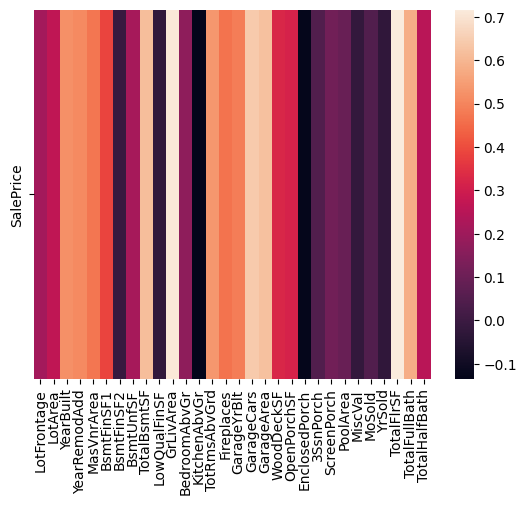

           LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
SalePrice          NaN      NaN   0.523273       0.50743         NaN   

           BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  LowQualFinSF  ...  \
SalePrice         NaN         NaN        NaN     0.613905           NaN  ...   

           EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  \
SalePrice            NaN        NaN          NaN       NaN      NaN     NaN   

           YrSold  TotalFlrSF  TotalFullBath  TotalHalfBath  
SalePrice     NaN    0.716876       0.582941            NaN  

[1 rows x 30 columns]
['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'TotalFlrSF', 'TotalFullBath']


In [4]:

# Draw a correlation between numerical features and SalePrice
fig, ax = plt.subplots()

corr_matrix = df_train_cleaned.select_dtypes(include=np.number).corr()

df_correlarion_with_price = corr_matrix\
                                .loc[["SalePrice"]]\
                                .drop("SalePrice", axis=1)

sns.heatmap(data=df_correlarion_with_price, 
            ax=ax, 
            xticklabels=True, 
            yticklabels=True)
plt.show()

# High correlation is only positive

# Find column names, which has correlation greater than correlation_min = 0.5
correlation_min = 0.5
clms_high_correlation = df_correlarion_with_price[df_correlarion_with_price >= correlation_min]\
                            .dropna(how='all', axis=1)\
                            .columns.tolist()

print(df_correlarion_with_price[df_correlarion_with_price >= correlation_min])

print(clms_high_correlation)
# The following columns have a strong linear impact on the sal price:
#'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea'

In [5]:
print(df_correlarion_with_price[["LotArea", "BsmtFinSF1", "Fireplaces"]])

            LotArea  BsmtFinSF1  Fireplaces
SalePrice  0.263837    0.386436    0.466968


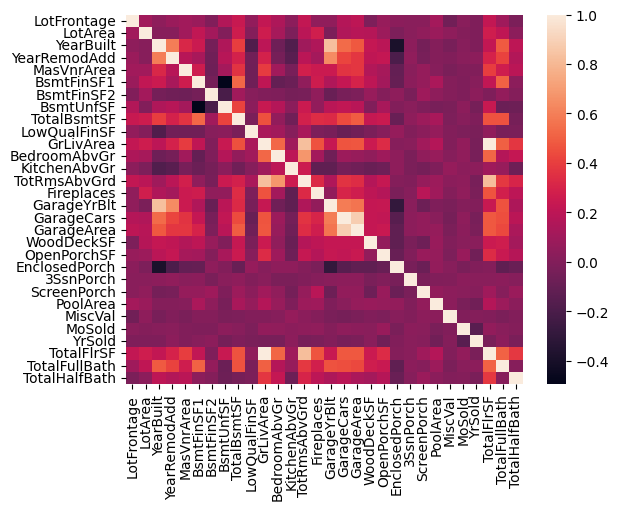

In [6]:
# Check features wihch correlate to each other to reduce features (only numeric features)

df_correlarion_without_price = corr_matrix\
                                    .drop("SalePrice", axis=1)\
                                    .drop("SalePrice", axis=0)

fig, ax = plt.subplots()                                        
sns.heatmap(data=df_correlarion_without_price, 
            ax=ax, 
            xticklabels=True, 
            yticklabels=True)
plt.show()

In [7]:
#  Find all pairs where correlation is  between .75 and 1
corr_indexes = df_correlarion_without_price[(df_correlarion_without_price > 0.75) & (df_correlarion_without_price < 1)]\
            .dropna(how='all', axis=1)\
            .dropna(how='all')\
            .stack()\
            .index\
            .tolist()

corr_indexes_set = list(map(tuple, set(map(frozenset, corr_indexes))))

print("\nCorrelated features")
print(corr_indexes_set)

# high correlated pairs of features are:
# ('1stFlrSF', 'TotalBsmtSF'), ('GarageYrBlt', 'YearBuilt'), ('GrLivArea', 'TotRmsAbvGrd'), ('GarageArea', 'GarageCars')

# Make a list of features which can be omitted, because correlated feature will be used instead
clms_to_be_omitted = ["1stFlrSF", "GarageYrBlt", "TotRmsAbvGrd", "GarageArea"]
clms_to_be_preserved = ["TotalBsmtSF", "YearBuilt", "GrLivArea", "GarageCars"]

# Features which have impacte on sales price:
# 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 
# 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea'

# find clms_to_be_omitted which are in clms_high_correlation
clms_to_replace = set(clms_high_correlation).intersection(set(clms_to_be_omitted))
clms_to_add = [clms_to_be_preserved[clms_to_be_omitted.index(clmn)] for clmn in list(clms_to_replace)]
print("\nFeatures to be replaced with correlated features")
print(clms_to_replace)
print("\nFeatures to be added to important numeric features")
print(clms_to_add)

# That are the numericcolumns which are important for the analysis
clmns_not_to_replace = set(clms_high_correlation).difference(set(clms_to_be_omitted))
clmns_numeric = list(clmns_not_to_replace.union(set(clms_to_add)))
print(clmns_numeric)



Correlated features
[('GarageYrBlt', 'YearBuilt'), ('GrLivArea', 'TotRmsAbvGrd'), ('GarageCars', 'GarageArea'), ('GrLivArea', 'TotalFlrSF'), ('TotalFlrSF', 'TotRmsAbvGrd')]

Features to be replaced with correlated features
{'GarageArea', 'TotRmsAbvGrd'}

Features to be added to important numeric features
['GarageCars', 'GrLivArea']
['TotalBsmtSF', 'YearRemodAdd', 'GrLivArea', 'GarageCars', 'TotalFlrSF', 'YearBuilt', 'TotalFullBath']


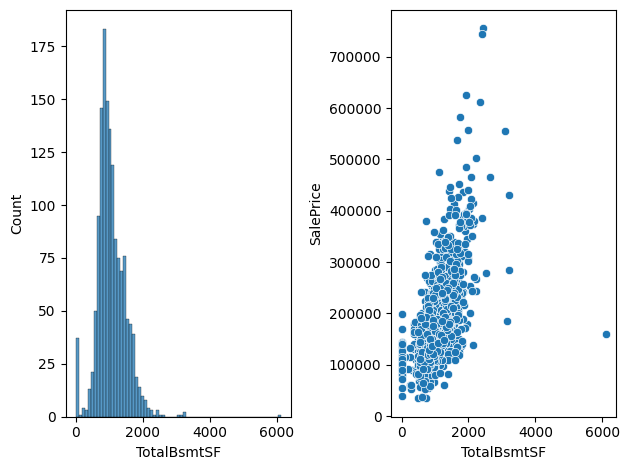

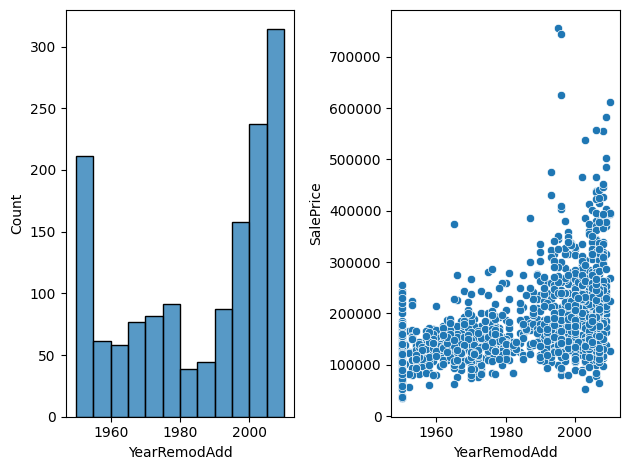

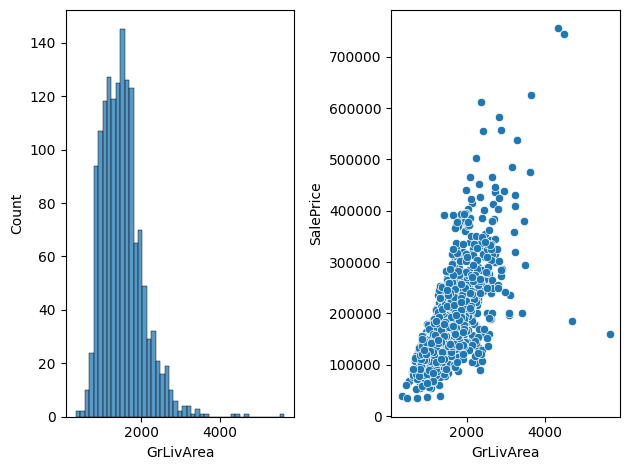

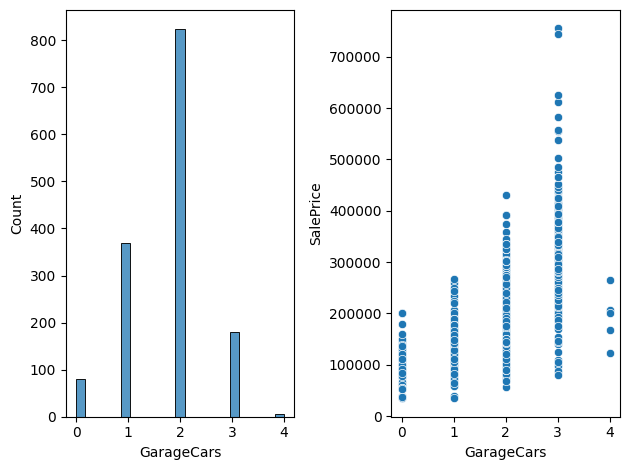

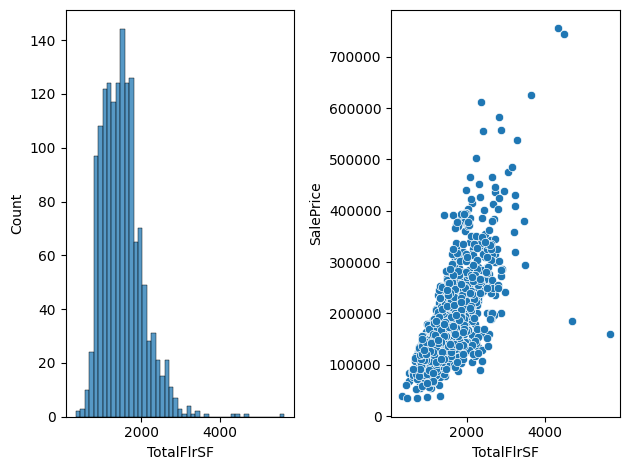

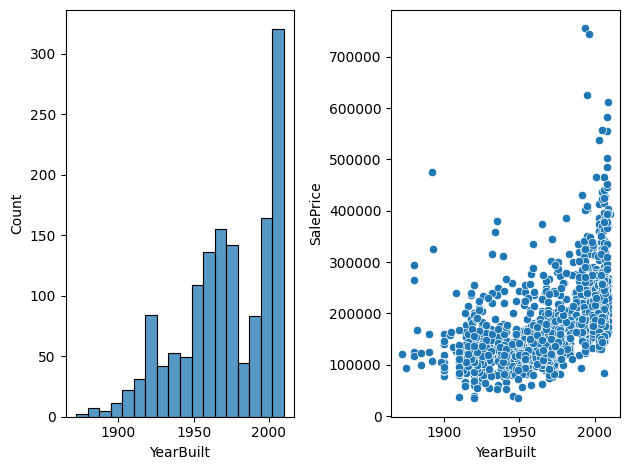

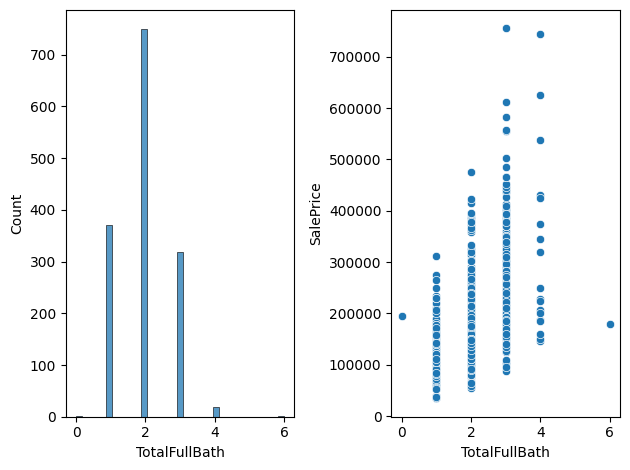

In [8]:
# One more time draw histogram and scatterplot for the chosen numeric features
for clmn in clmns_numeric:
    fig, axs = plt.subplots(ncols=2)
    sns.histplot(df_train_cleaned, x=clmn, ax=axs[0])
    sns.scatterplot(df_train_cleaned, x=clmn, y="SalePrice", ax=axs[1])
    plt.tight_layout()
    plt.show()

In [ ]:
# What conclusion can one draw from that???????????????????????????

### Now analyse categorical features to choose the important ones.

In [9]:
# Now we have to choose categorcal variables which are important for us
df_train_categorical = df_train_cleaned.select_dtypes(exclude=np.number)


categorical_columns_all = df_train_categorical.columns.tolist()

print(categorical_columns_all)


['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


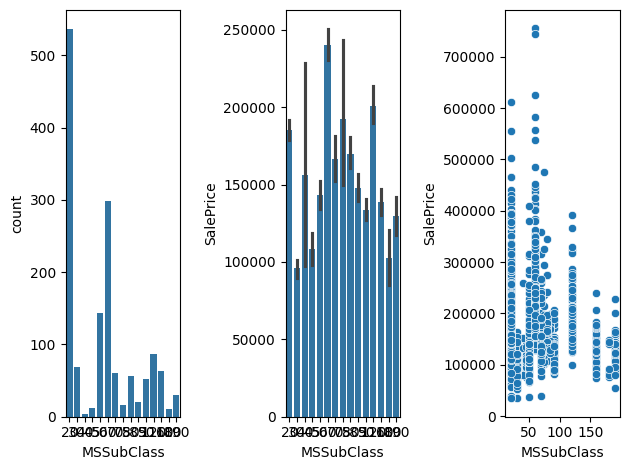

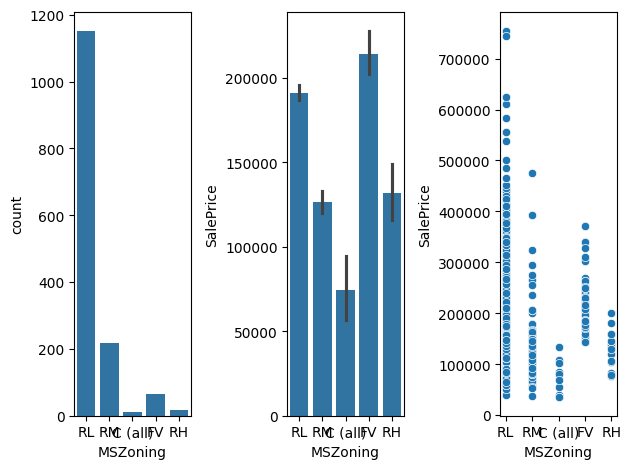

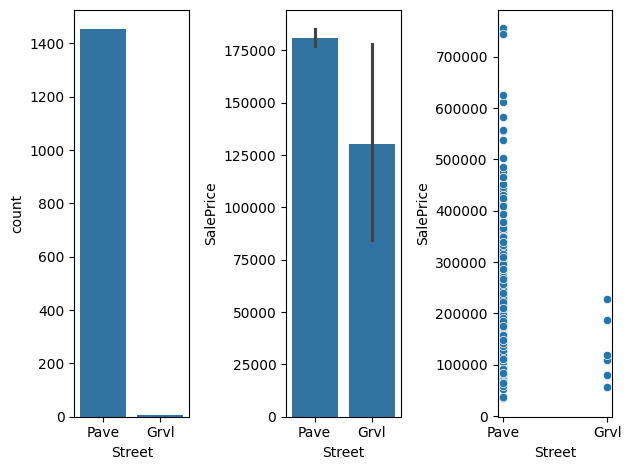

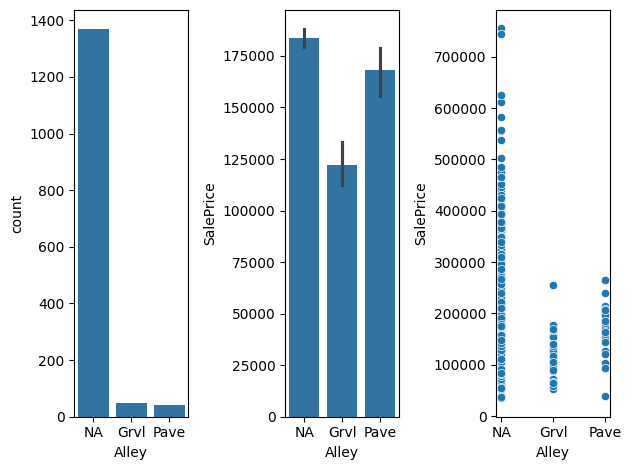

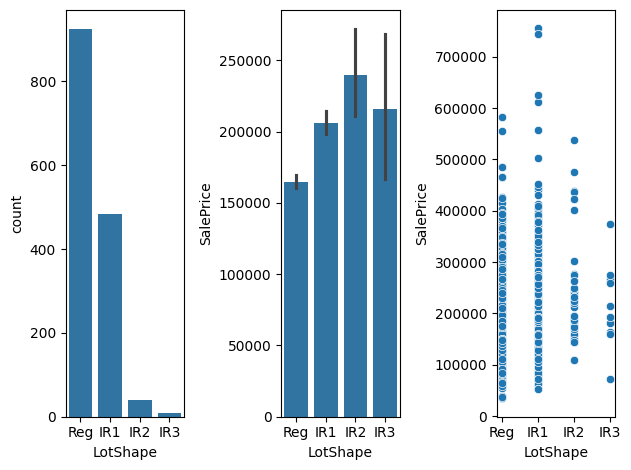

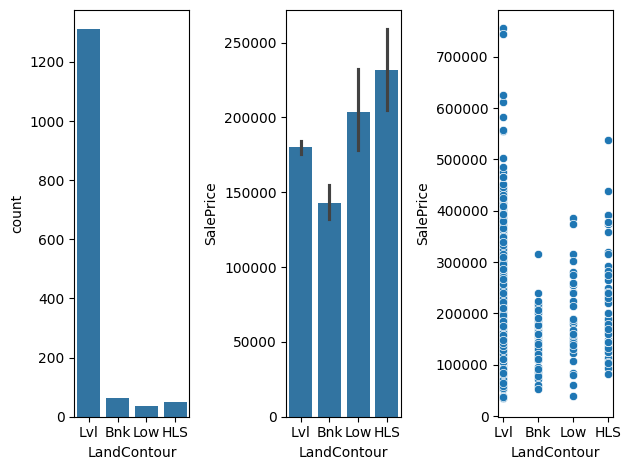

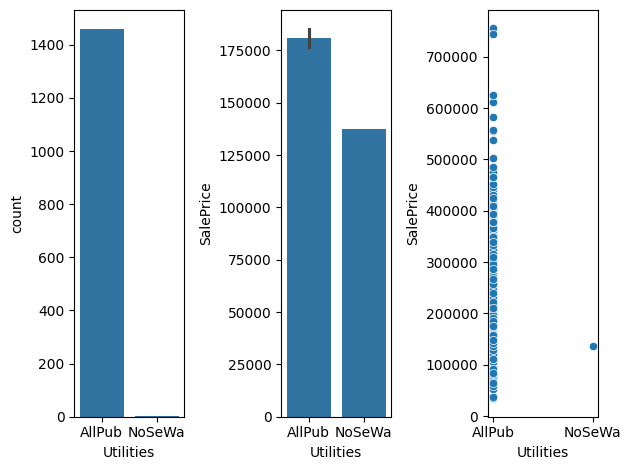

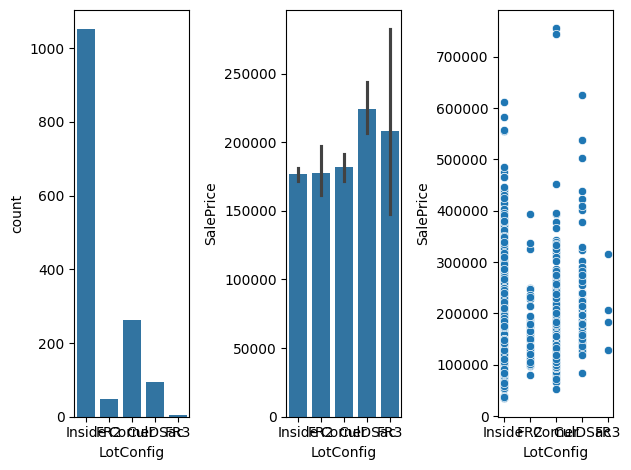

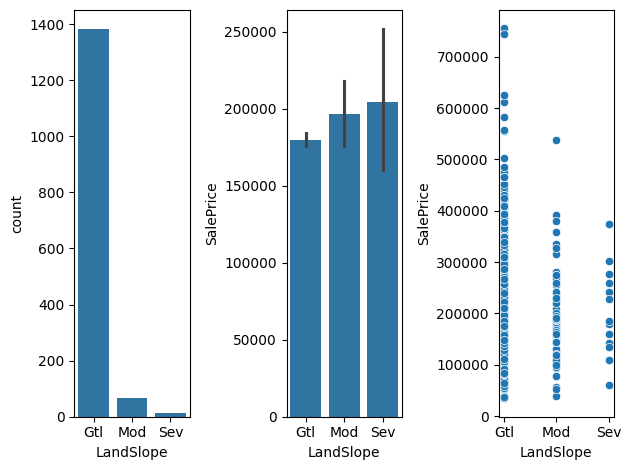

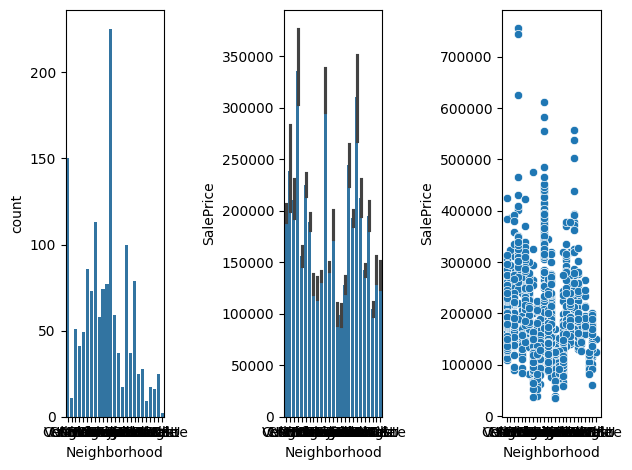

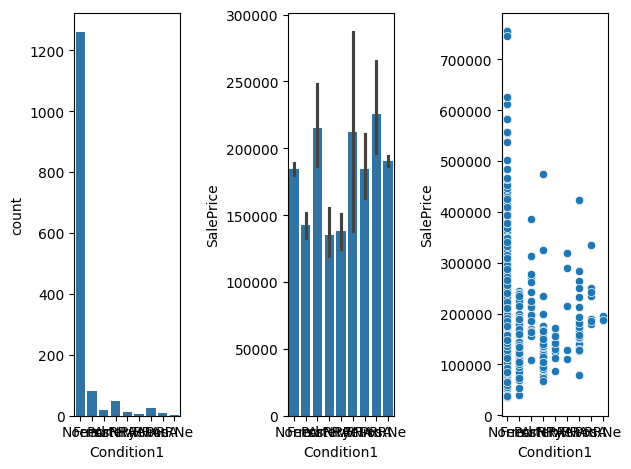

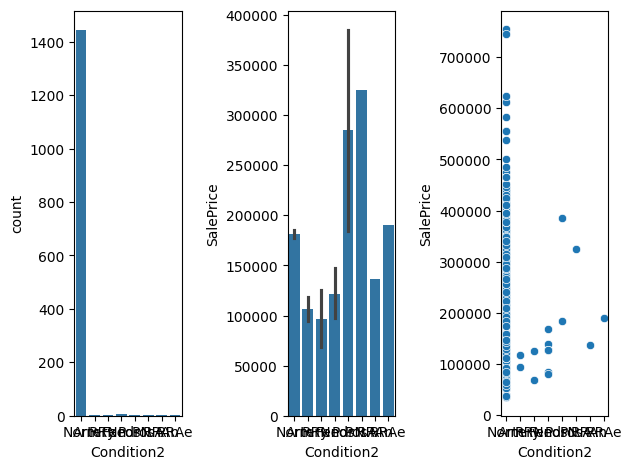

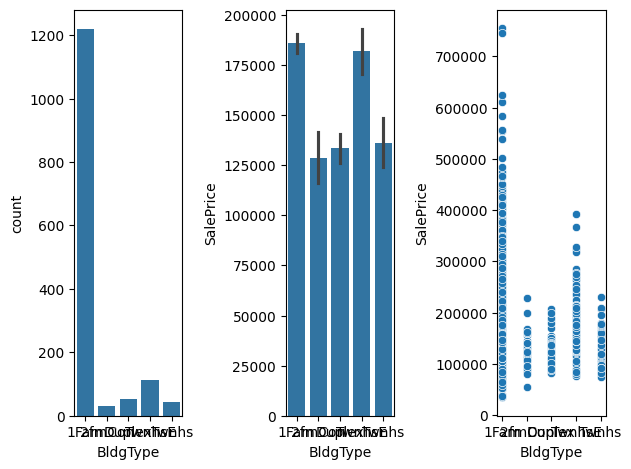

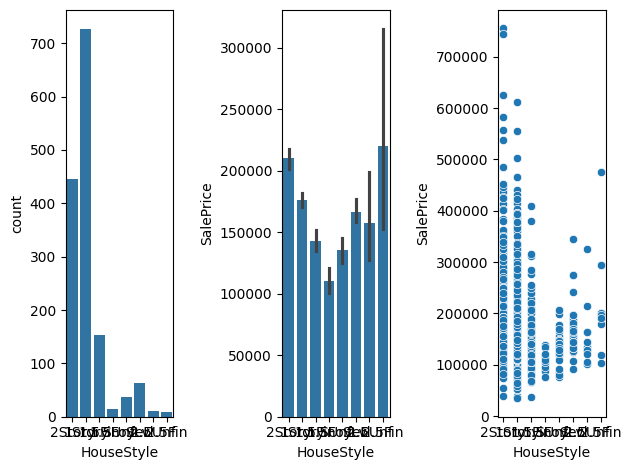

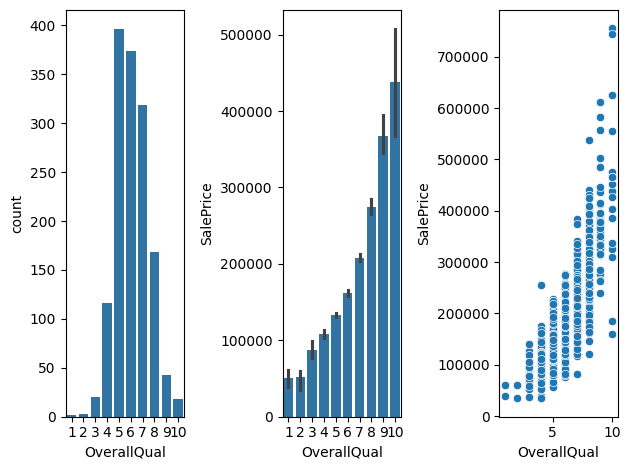

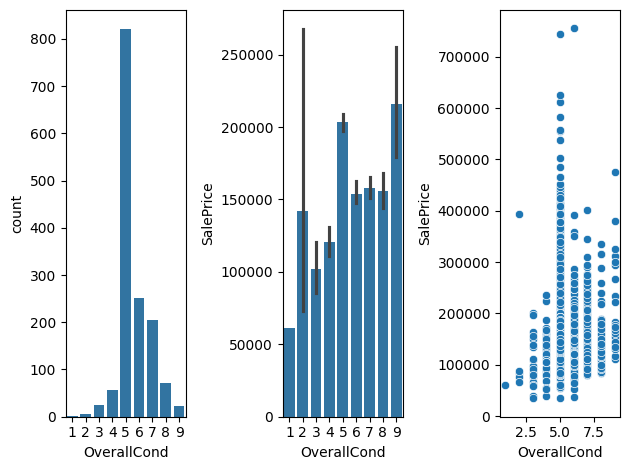

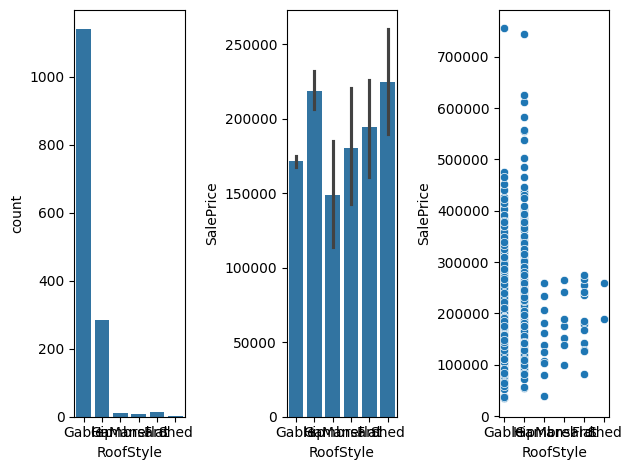

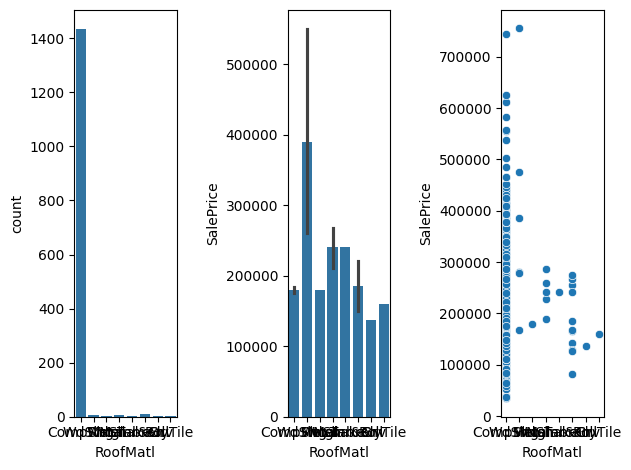

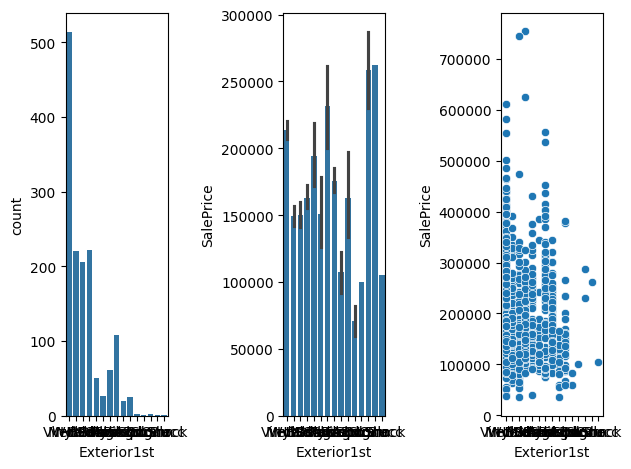

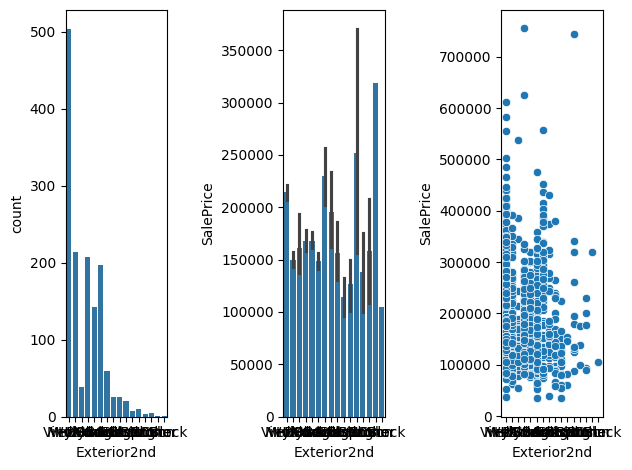

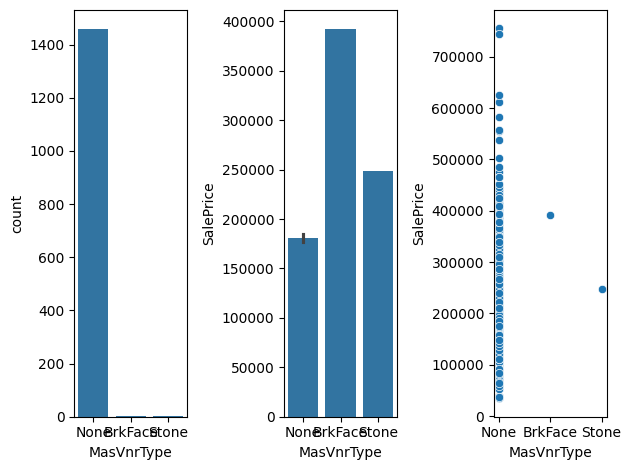

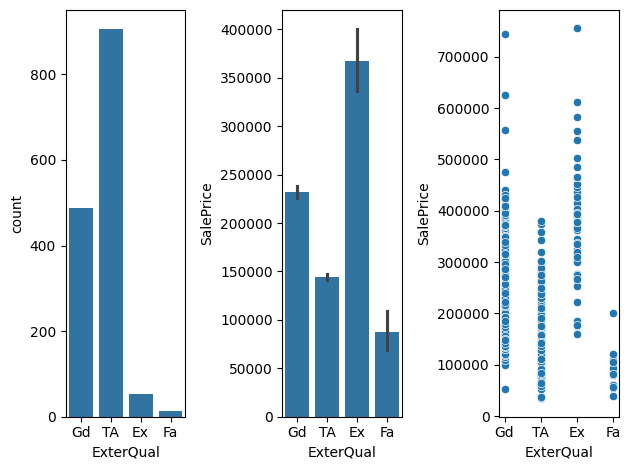

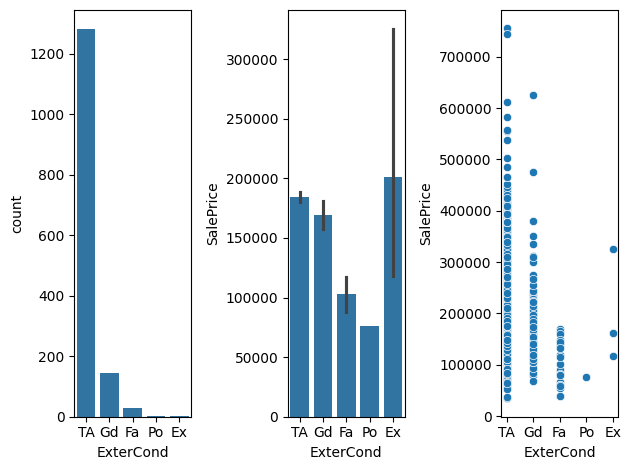

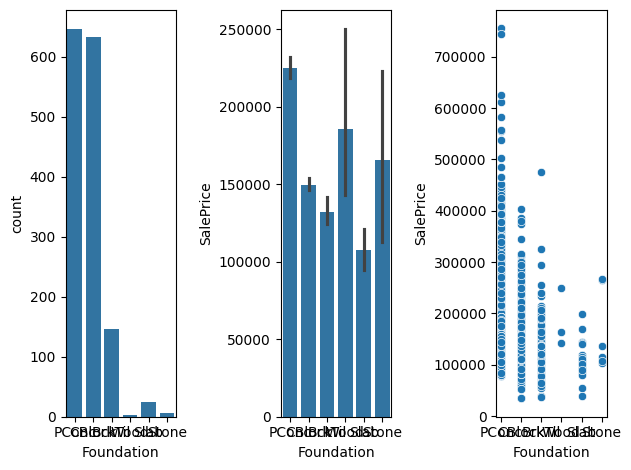

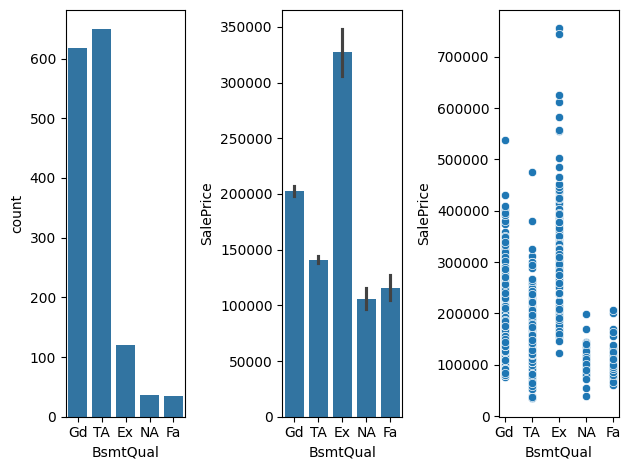

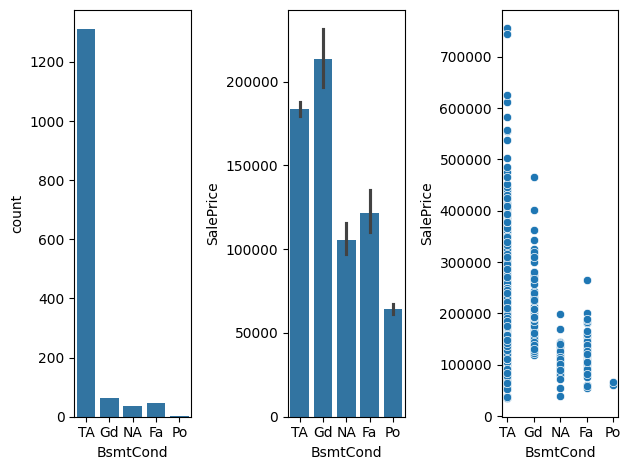

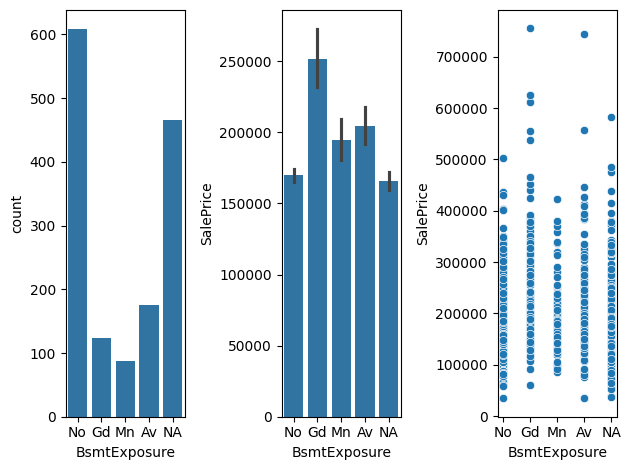

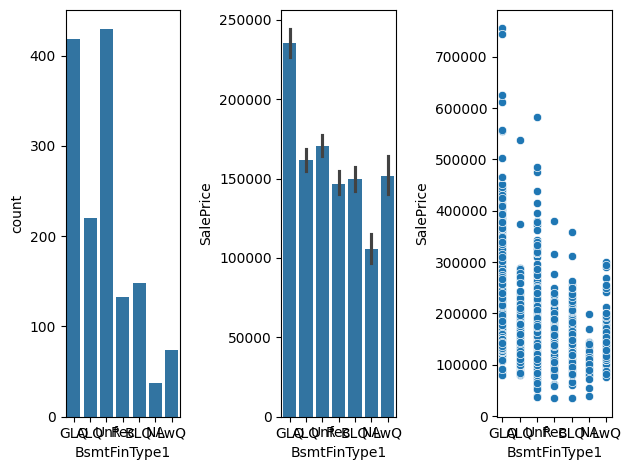

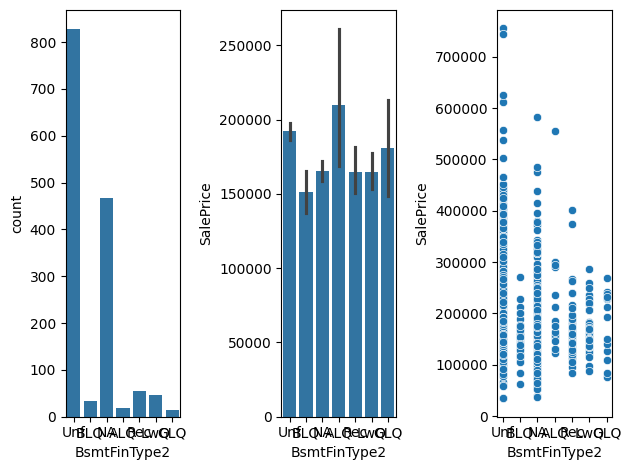

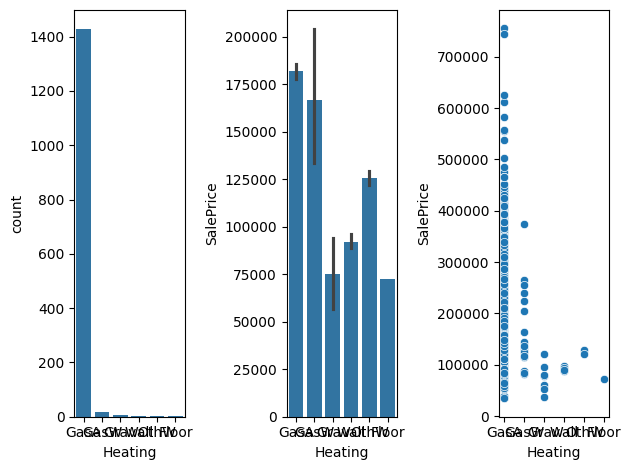

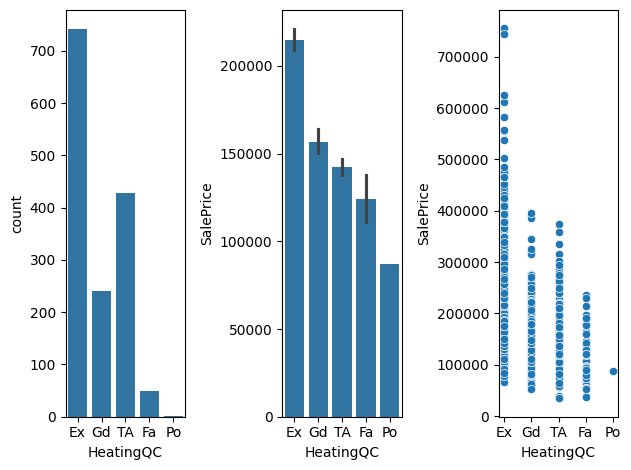

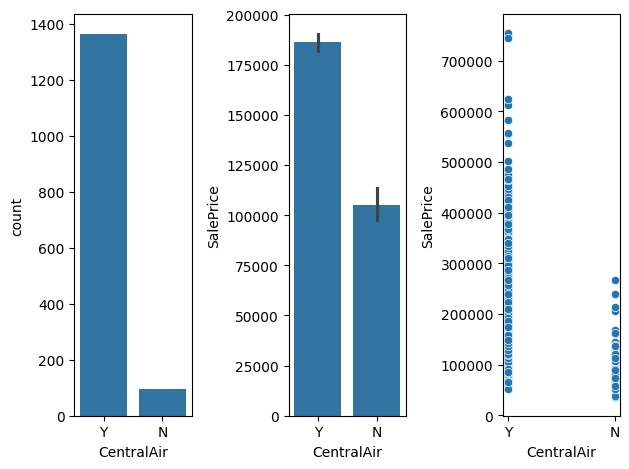

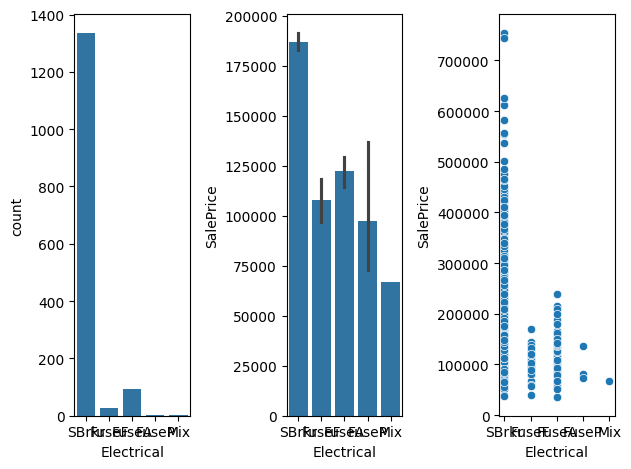

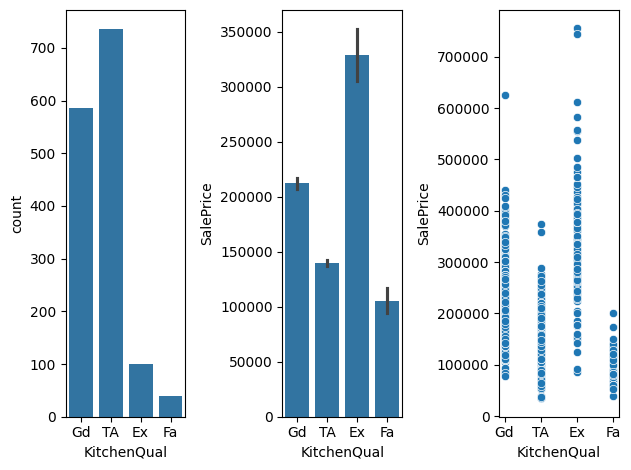

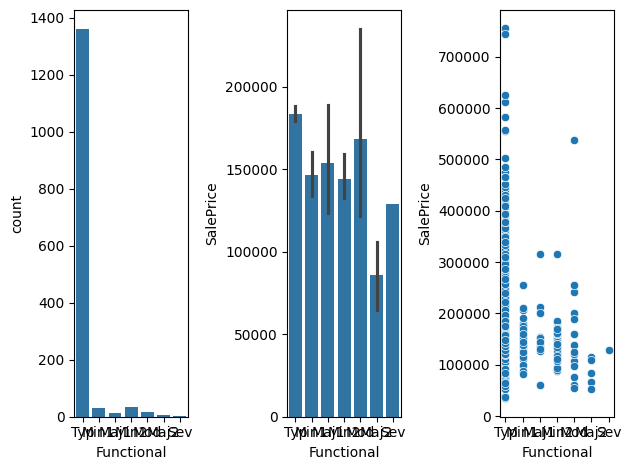

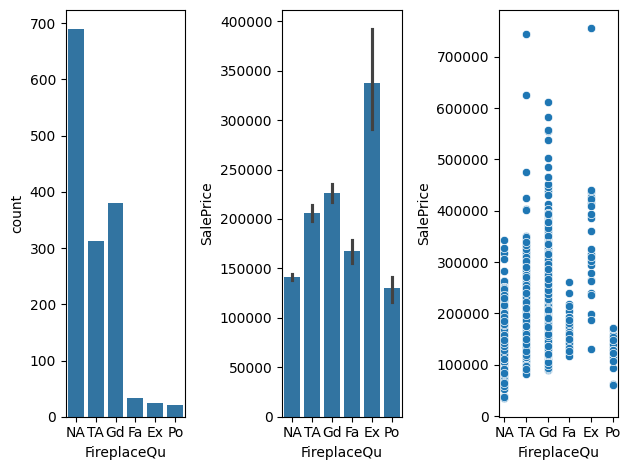

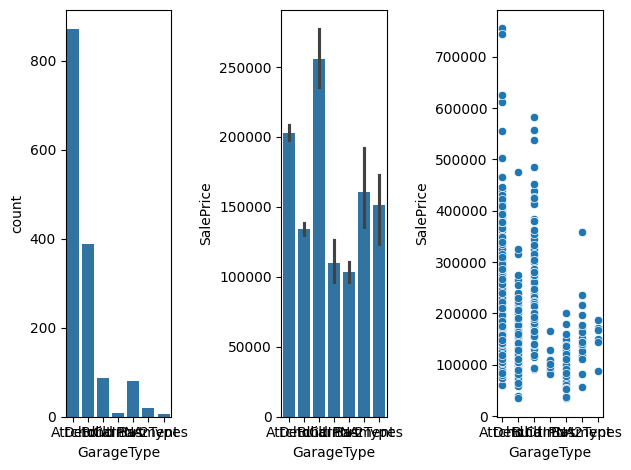

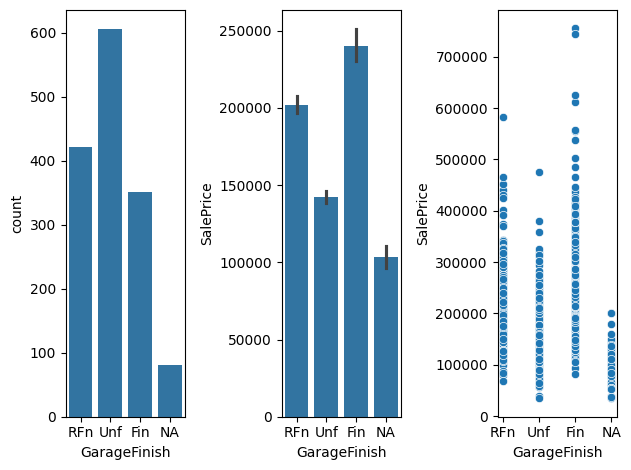

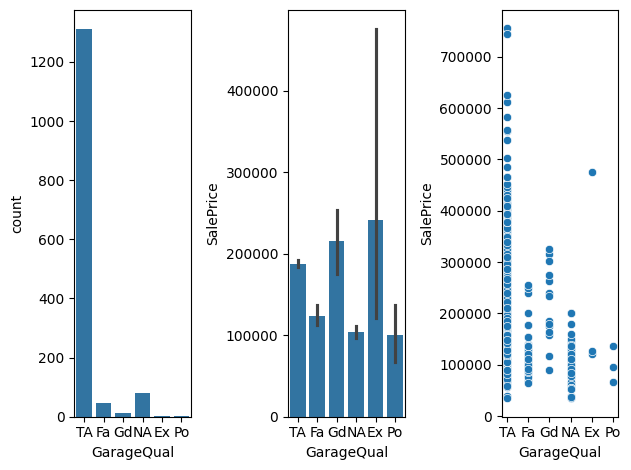

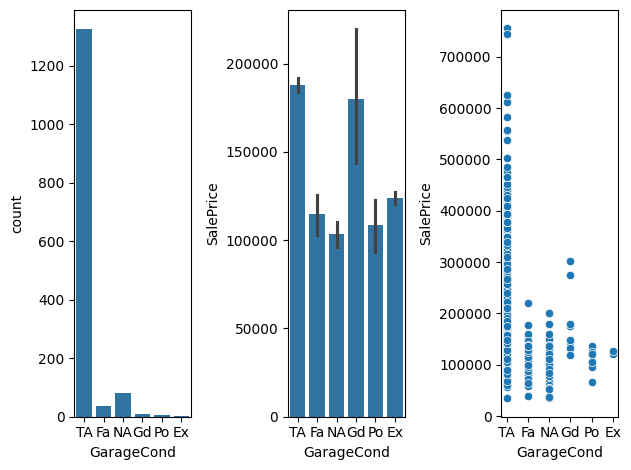

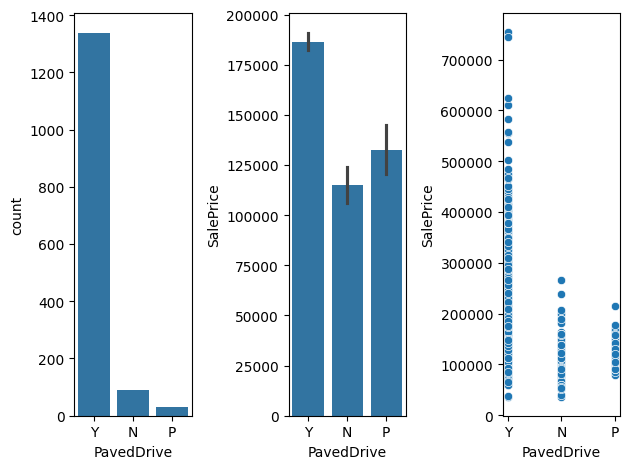

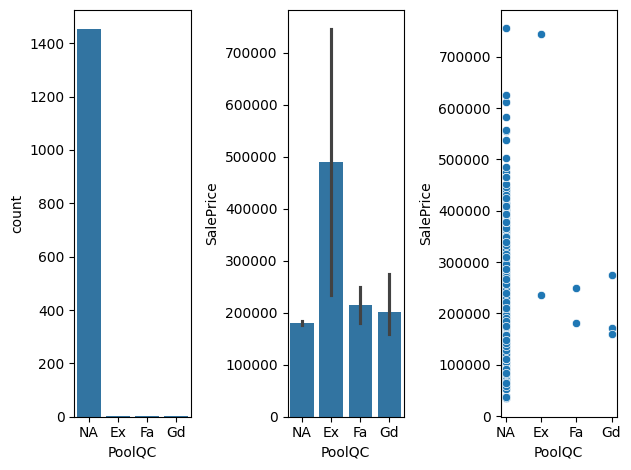

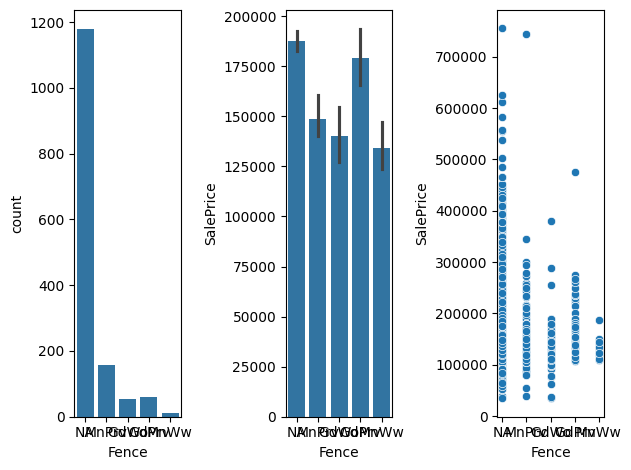

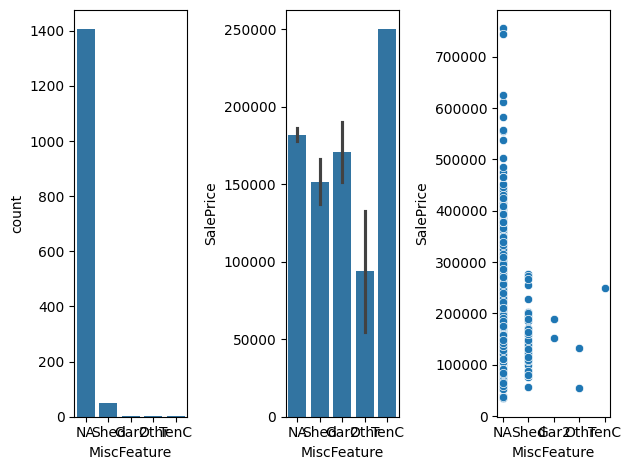

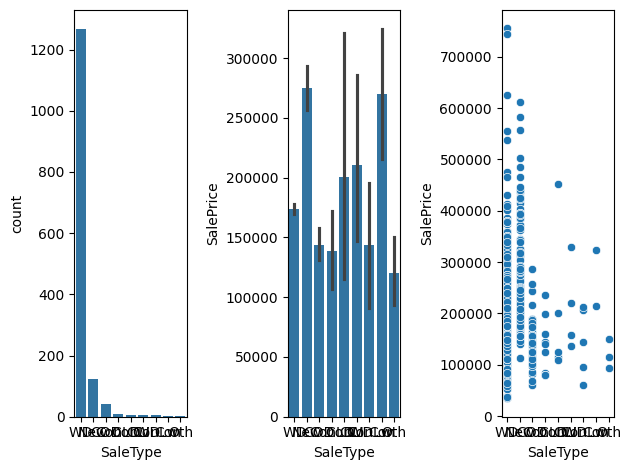

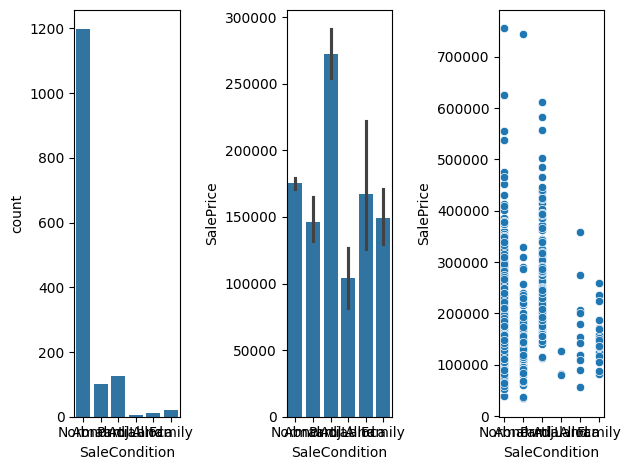

In [10]:
for clmn in categorical_columns_all:
    fig, axs = plt.subplots(ncols=3)
    sns.countplot(df_train_cleaned, x=clmn, ax=axs[0])
    sns.barplot(df_train_cleaned, x=clmn, y="SalePrice", ax=axs[1])
    sns.scatterplot(df_train_cleaned, x=clmn, y="SalePrice", ax=axs[2])
    plt.tight_layout()
    plt.show()

### From the plots one can conclude that the following features has influence on the sale price:
1. "MSSubClass" could influence the sale price
2. "MSZoning"
3. "Street" ??????????????????????
4. "LotShape" have not a big influence on the sale 
5. "LandContour"
6. "Utilities"
7. "Neighborhood"
8. "Condition1"
9. "Condition2"
10. "BldgType"
11. "HouseStyle"
12. "OverallQual"
13. "OverallCond"
14. "RoofStyle"
15. "RoofMatl"
16. "Exterior1st"
17. "Exterior2st"
18. "MasVnrType"
19. "ExterQual"
20. "ExterCond"
21. "Foundation"
22. "BsmtQual"
23. "BsmtCond"
24. "BsmtExposure"
25. "Heating"
26. "HeatingQC"
27. "CentralAir"
28. "Electrical"
29. "KitchenQual"
30. "FireplaceQu"
31. "GarageType"
32. "GarageFinish"
33. "GarageQual"
34. "GarageCond"
35. "PavedDrive"
36. "PoolQC"
37. "SaleType"
38. "SaleCondition"

### The feauture which can be neglected are the following:
1. "Alley" - da es bei "NA" value wird der Preice hoch, hat es vermutlich Einfluss
2. "LotConfig"
3. "LandSlope"
4. "BsmtFinType1"
5. "BsmtFinType2"
6. "Functional"
7. "Fence"
8. "MiscFeature"

### With help of CatBoostRegressor we will try to find out which categorical feautures have the most impact in order to reduce the number of features

In [11]:
# put all categorical features to type String
df_train_cleaned[categorical_columns_all] = df_train_cleaned[categorical_columns_all].astype("category")

print(df_train_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1459 non-null   category
 1   MSZoning       1459 non-null   category
 2   LotFrontage    1459 non-null   float64 
 3   LotArea        1459 non-null   int64   
 4   Street         1459 non-null   category
 5   Alley          1459 non-null   category
 6   LotShape       1459 non-null   category
 7   LandContour    1459 non-null   category
 8   Utilities      1459 non-null   category
 9   LotConfig      1459 non-null   category
 10  LandSlope      1459 non-null   category
 11  Neighborhood   1459 non-null   category
 12  Condition1     1459 non-null   category
 13  Condition2     1459 non-null   category
 14  BldgType       1459 non-null   category
 15  HouseStyle     1459 non-null   category
 16  OverallQual    1459 non-null   category
 17  OverallCond    1459 non-null   categor

In [12]:

# split data to use CatBoostClassifier to find feature importance
# GarageYrBlt feature is removed because there are too many null values if there is no garage
X_train, X_test, y_train, y_test = train_test_split(
    df_train_cleaned.drop(columns=["SalePrice", "GarageYrBlt"]), df_train_cleaned["SalePrice"], test_size=0.33, random_state=42)

In [ ]:
"""from catboost import CatBoostRegressor, Pool

train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)

# Data to tune the catBoostRegressor model
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

cat_Boost_Regressor = CatBoostRegressor(loss_function='RMSE')

cat_Boost_Regressor.fit(X_train, y_train, 
                         cat_features = categorical_columns_all)"""

In [13]:
from catboost import CatBoostRegressor, Pool

cat_Boost_Regressor = CatBoostRegressor(iterations=200,
                                        learning_rate=0.1,
                                        depth=6,
                                        loss_function='RMSE')

cat_Boost_Regressor.fit(X_train, y_train, 
                         cat_features = categorical_columns_all)



0:	learn: 71435.6255344	total: 146ms	remaining: 29.1s
1:	learn: 67348.9007418	total: 192ms	remaining: 19s
2:	learn: 63714.7917175	total: 237ms	remaining: 15.6s
3:	learn: 60234.9714522	total: 282ms	remaining: 13.8s
4:	learn: 57224.5362566	total: 307ms	remaining: 12s
5:	learn: 54178.5421337	total: 349ms	remaining: 11.3s
6:	learn: 51457.7347427	total: 392ms	remaining: 10.8s
7:	learn: 49011.5177939	total: 439ms	remaining: 10.5s
8:	learn: 47143.5839605	total: 482ms	remaining: 10.2s
9:	learn: 45259.0910733	total: 527ms	remaining: 10s
10:	learn: 43213.7459079	total: 572ms	remaining: 9.82s
11:	learn: 41513.2813303	total: 614ms	remaining: 9.62s
12:	learn: 39803.4365192	total: 657ms	remaining: 9.45s
13:	learn: 38323.8027665	total: 698ms	remaining: 9.28s
14:	learn: 37087.2374676	total: 744ms	remaining: 9.18s
15:	learn: 36051.1295373	total: 792ms	remaining: 9.11s
16:	learn: 34960.3424420	total: 833ms	remaining: 8.97s
17:	learn: 33925.1062075	total: 879ms	remaining: 8.88s
18:	learn: 32790.5402861	t

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import math

"""# Make predictions
y_pred = cat_Boost_Regressor.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")"""
# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")

NameError: name 'y_pred' is not defined

In [15]:
# Get feature importances (default: Prediction Values Change)
feature_importances = cat_Boost_Regressor.get_feature_importance()

clmns_sorted_by_importance = (list(zip(X_test.columns, feature_importances)))
clmns_sorted_by_importance = sorted(clmns_sorted_by_importance, key=lambda x:x[1], reverse=True)

print("Feature Importances (Prediction Values Change):")
for feature, importance in clmns_sorted_by_importance:
    print(f"{feature}: {importance:.2f}")

# Take the features with importance > 0
clmns_important_features = filter(lambda x:x[1] > 0, clmns_sorted_by_importance)
clmns_important_features = list(map(lambda x:x[0], clmns_important_features))
print(clmns_important_features)

""" Feature Importances (Prediction Values Change):
GrLivArea: 12.25
TotalFlrSF: 10.80
GarageCars: 10.00
ExterQual: 9.51
TotalBsmtSF: 8.30
OverallQual: 5.93
TotalFullBath: 4.09
BsmtFinSF1: 3.98
KitchenQual: 3.29
BsmtQual: 3.03
YearRemodAdd: 2.51
LotArea: 2.40
GarageFinish: 2.31
YearBuilt: 1.58
LandContour: 1.53
Fireplaces: 1.42
TotalHalfBath: 1.16
LotFrontage: 1.12
Neighborhood: 1.04
FireplaceQu: 1.03
SaleCondition: 0.90
OverallCond: 0.87
MSZoning: 0.79
OpenPorchSF: 0.73
BldgType: 0.65
TotRmsAbvGrd: 0.63
WoodDeckSF: 0.62
LotShape: 0.56
BsmtUnfSF: 0.55
GarageType: 0.52
PoolQC: 0.48
GarageQual: 0.43
ScreenPorch: 0.43
MoSold: 0.43
Condition1: 0.40
GarageArea: 0.37
MasVnrType: 0.34
BsmtExposure: 0.26
CentralAir: 0.21
KitchenAbvGr: 0.21
YrSold: 0.19
Functional: 0.19
MasVnrArea: 0.19
Alley: 0.15
Foundation: 0.15
BsmtCond: 0.15
RoofStyle: 0.14
LandSlope: 0.13
RoofMatl: 0.13
Electrical: 0.11
Fence: 0.11
GarageCond: 0.11
LotConfig: 0.10
MSSubClass: 0.07
ExterCond: 0.06
BsmtFinSF2: 0.05
PavedDrive: 0.05
Exterior1st: 0.04
Condition2: 0.04
BedroomAbvGr: 0.03
3SsnPorch: 0.03
BsmtFinType1: 0.03
BsmtFinType2: 0.03
EnclosedPorch: 0.02
LowQualFinSF: 0.02
MiscFeature: 0.01
Heating: 0.01
PoolArea: 0.01
HeatingQC: 0.00
"""

Feature Importances (Prediction Values Change):
GrLivArea: 12.25
TotalFlrSF: 10.80
GarageCars: 10.00
ExterQual: 9.51
TotalBsmtSF: 8.30
OverallQual: 5.93
TotalFullBath: 4.09
BsmtFinSF1: 3.98
KitchenQual: 3.29
BsmtQual: 3.03
YearRemodAdd: 2.51
LotArea: 2.40
GarageFinish: 2.31
YearBuilt: 1.58
LandContour: 1.53
Fireplaces: 1.42
TotalHalfBath: 1.16
LotFrontage: 1.12
Neighborhood: 1.04
FireplaceQu: 1.03
SaleCondition: 0.90
OverallCond: 0.87
MSZoning: 0.79
OpenPorchSF: 0.73
BldgType: 0.65
TotRmsAbvGrd: 0.63
WoodDeckSF: 0.62
LotShape: 0.56
BsmtUnfSF: 0.55
GarageType: 0.52
PoolQC: 0.48
GarageQual: 0.43
ScreenPorch: 0.43
MoSold: 0.43
Condition1: 0.40
GarageArea: 0.37
MasVnrType: 0.34
BsmtExposure: 0.26
CentralAir: 0.21
KitchenAbvGr: 0.21
YrSold: 0.19
Functional: 0.19
MasVnrArea: 0.19
Alley: 0.15
Foundation: 0.15
BsmtCond: 0.15
RoofStyle: 0.14
LandSlope: 0.13
RoofMatl: 0.13
Electrical: 0.11
Fence: 0.11
GarageCond: 0.11
LotConfig: 0.10
MSSubClass: 0.07
ExterCond: 0.06
BsmtFinSF2: 0.05
PavedDrive: 

' Feature Importances (Prediction Values Change):\nGrLivArea: 12.25\nTotalFlrSF: 10.80\nGarageCars: 10.00\nExterQual: 9.51\nTotalBsmtSF: 8.30\nOverallQual: 5.93\nTotalFullBath: 4.09\nBsmtFinSF1: 3.98\nKitchenQual: 3.29\nBsmtQual: 3.03\nYearRemodAdd: 2.51\nLotArea: 2.40\nGarageFinish: 2.31\nYearBuilt: 1.58\nLandContour: 1.53\nFireplaces: 1.42\nTotalHalfBath: 1.16\nLotFrontage: 1.12\nNeighborhood: 1.04\nFireplaceQu: 1.03\nSaleCondition: 0.90\nOverallCond: 0.87\nMSZoning: 0.79\nOpenPorchSF: 0.73\nBldgType: 0.65\nTotRmsAbvGrd: 0.63\nWoodDeckSF: 0.62\nLotShape: 0.56\nBsmtUnfSF: 0.55\nGarageType: 0.52\nPoolQC: 0.48\nGarageQual: 0.43\nScreenPorch: 0.43\nMoSold: 0.43\nCondition1: 0.40\nGarageArea: 0.37\nMasVnrType: 0.34\nBsmtExposure: 0.26\nCentralAir: 0.21\nKitchenAbvGr: 0.21\nYrSold: 0.19\nFunctional: 0.19\nMasVnrArea: 0.19\nAlley: 0.15\nFoundation: 0.15\nBsmtCond: 0.15\nRoofStyle: 0.14\nLandSlope: 0.13\nRoofMatl: 0.13\nElectrical: 0.11\nFence: 0.11\nGarageCond: 0.11\nLotConfig: 0.10\nMSSubC

### Try to select important features on the base of feature_importance method

In [16]:
from sklearn.feature_selection import SelectFromModel

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectFromModel(CatBoostRegressor(iterations=200,
                                        learning_rate=0.1,
                                        depth=6,
                                        loss_function='RMSE',
										cat_features=categorical_columns_all))
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = CatBoostRegressor(iterations=200,
                        learning_rate=0.1,
                        depth=6,
                        loss_function='RMSE')
# Find categorical features

selected_catBoostRegress_columns = fs.get_feature_names_out()
print(selected_catBoostRegress_columns)
categorical_columns_important = list(set(categorical_columns_all)\
									.intersection(set(selected_catBoostRegress_columns)))

print(categorical_columns_important)


model.fit(pd.DataFrame(data=X_train_fs, columns=selected_catBoostRegress_columns),
		  				 y_train, 
                         cat_features = categorical_columns_important)

# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
# Calculate regression metrics
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
explained_variance = explained_variance_score(y_test, yhat)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")

# R_squares and Explained variance Score are slightly better

0:	learn: 71435.6255344	total: 43.7ms	remaining: 8.7s
1:	learn: 67348.9007418	total: 88.7ms	remaining: 8.78s
2:	learn: 63714.7917175	total: 130ms	remaining: 8.53s
3:	learn: 60234.9714522	total: 170ms	remaining: 8.35s
4:	learn: 57224.5362566	total: 197ms	remaining: 7.67s
5:	learn: 54178.5421337	total: 239ms	remaining: 7.72s
6:	learn: 51457.7347427	total: 280ms	remaining: 7.71s
7:	learn: 49011.5177939	total: 322ms	remaining: 7.74s
8:	learn: 47143.5839605	total: 363ms	remaining: 7.7s
9:	learn: 45259.0910733	total: 403ms	remaining: 7.66s
10:	learn: 43213.7459079	total: 442ms	remaining: 7.6s
11:	learn: 41513.2813303	total: 484ms	remaining: 7.58s
12:	learn: 39803.4365192	total: 526ms	remaining: 7.56s
13:	learn: 38323.8027665	total: 566ms	remaining: 7.52s
14:	learn: 37087.2374676	total: 608ms	remaining: 7.5s
15:	learn: 36051.1295373	total: 649ms	remaining: 7.46s
16:	learn: 34960.3424420	total: 689ms	remaining: 7.42s
17:	learn: 33925.1062075	total: 734ms	remaining: 7.42s
18:	learn: 32790.54028

### CatBoostModel chose the following features

#### Categorical:
1. 'KitchenQual', 
2. 'ExterQual', 
3. 'LandContour', 
4. 'GarageFinish', 
5. 'BsmtQual', 
6. 'OverallQual'

#### Numerical:
1. 'LotArea' 
2. 'YearBuilt' 
3. 'YearRemodAdd'
4. 'BsmtFinSF1' 
5. 'TotalBsmtSF' 
6. 'GrLivArea'
7. 'Fireplaces' 
8. 'GarageCars' 
9. 'TotalFlrSF'
10. 'TotalFullBath'

#### The numeric features selected in the previous steps are:
1. 'GrLivArea', '
2. 'YearBuilt', 
3. 'TotalFullBath', 
4. 'GarageCars', 
5. 'YearRemodAdd', 
6. 'TotalBsmtSF', 
7. 'TotalFlrSF'

That means the model chose 3 more important numeric features:
1. 'LotArea' 
2. 'BsmtFinSF1'
3. 'Fireplaces'

In [17]:

# Check the correlation between the sale price and the numeric features which the model additionaly selected
print(df_correlarion_with_price[["LotArea", "BsmtFinSF1", "Fireplaces"]])

# Only "Fireplaces" correlation is greater than 0.45. The rest is smaller than 0.4
# There can exist non linear realtionship between ["LotArea", "BsmtFinSF1", "Fireplaces"] and "Sale Price"

            LotArea  BsmtFinSF1  Fireplaces
SalePrice  0.263837    0.386436    0.466968


In [18]:
# Choose the numeric and categorical features offered by that model
features_numeric = ['LotArea', 'YearBuilt', 'YearRemodAdd',
                    'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea',
                    'Fireplaces', 'GarageCars', 'TotalFlrSF',
                    'TotalFullBath']
features_categorical = ['KitchenQual', 'ExterQual', 'LandContour', 'GarageFinish', 'BsmtQual', 'OverallQual']

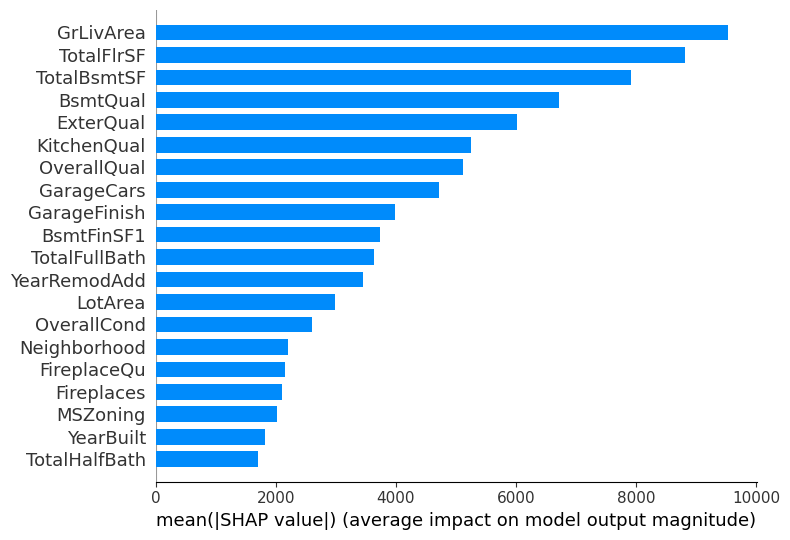

In [19]:
# Explain feature importance using SHAP
explainer = shap.Explainer(cat_Boost_Regressor)
#shap_values = explainer.shap_values(X_test)
shap_values = explainer(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size= 0.2)
plt.show()

In [20]:
#explainer = shap.Explainer(cat_Boost_Regressor)
#shap_values = explainer(X_test)

In [21]:
print(shap_values[0])

.values =
array([ 1.63498982e+02,  1.94278428e+03, -3.96487220e+02, -2.25705533e+03,
        0.00000000e+00,  1.23883623e+01,  1.56407539e+03, -4.76971667e+02,
        0.00000000e+00,  2.38347636e+01,  3.26937725e+02, -1.57498265e+03,
       -3.12764611e+03,  9.33524809e+01,  4.53837082e+02,  0.00000000e+00,
       -6.87232284e+03,  2.93218062e+03, -9.14252483e+02, -6.04123423e+03,
        4.65762521e+02, -5.29063643e+01, -2.36787898e+00,  0.00000000e+00,
       -1.18675634e+03, -1.19144716e+02, -5.07900462e+03,  1.39326784e+02,
       -5.59203038e+02, -5.91834065e+03, -2.77872363e+03, -2.00663353e+02,
       -5.09115219e+02, -4.01676889e+03, -7.66145333e+00, -6.87066111e+01,
        2.28910413e+02, -8.87886716e+03,  1.67774609e+02,  9.43995866e+00,
       -2.10948404e+03,  1.62164349e+02, -9.41435386e+00, -1.27148078e+04,
       -8.36050521e+01,  9.47597936e+01, -4.90194139e+03, -6.07093946e+02,
        2.42714989e+02, -2.24459536e+03, -2.47193219e+03, -1.17595848e+03,
       -6.17187

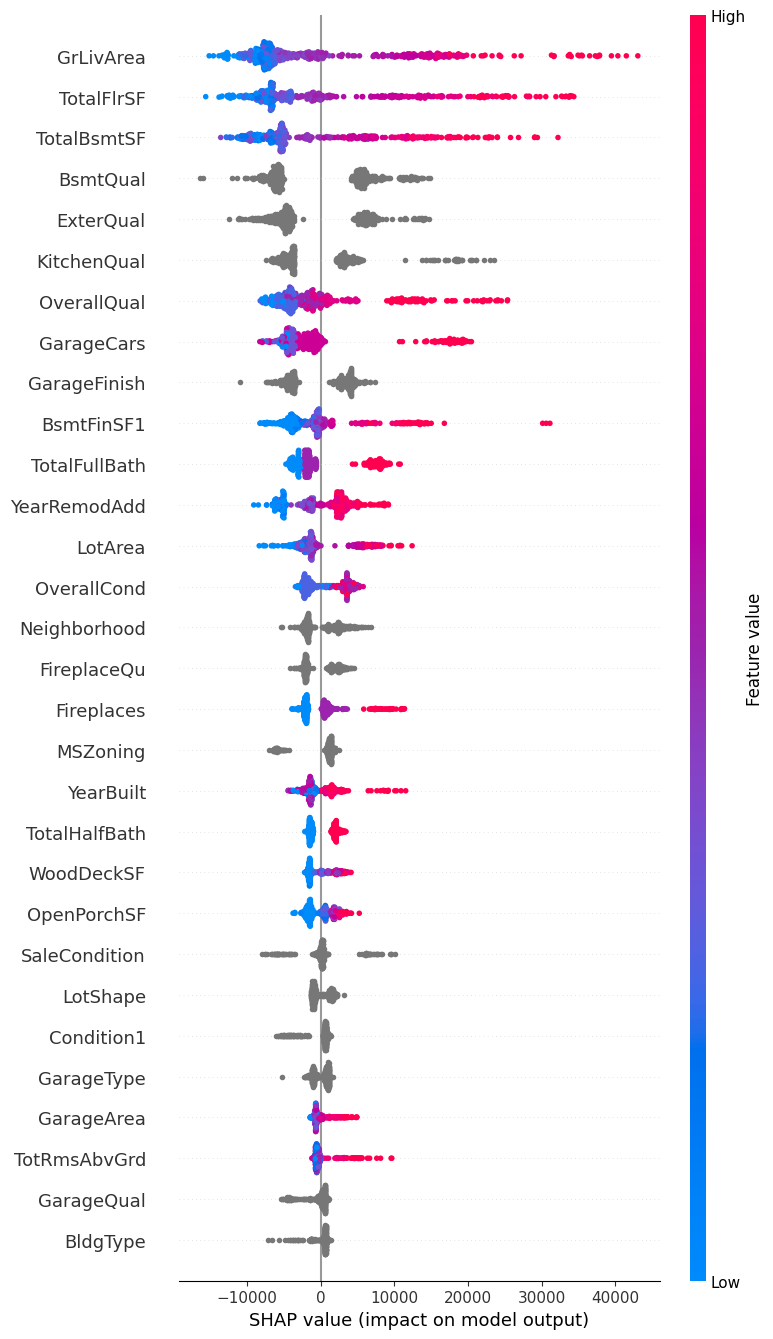

In [22]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, show=False, max_display=30)

plt.tight_layout()
plt.show()

In [23]:
# Get important data according to SHAP
#print(shap_values)
vals= np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head()
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(feature_importance)


#clmns_important_features

         col_name  feature_importance_vals
43      GrLivArea              9534.847252
72     TotalFlrSF              8814.862512
37    TotalBsmtSF              7925.561933
29       BsmtQual              6723.037463
26      ExterQual              6023.460177
46    KitchenQual              5257.464257
16    OverallQual              5116.971738
53     GarageCars              4720.017016
52   GarageFinish              3982.792392
33     BsmtFinSF1              3735.163720
73  TotalFullBath              3631.307994
19   YearRemodAdd              3450.182471
3         LotArea              2987.457684
17    OverallCond              2613.151100
11   Neighborhood              2202.256558
50    FireplaceQu              2159.104205
49     Fireplaces              2110.768691
1        MSZoning              2017.677290
18      YearBuilt              1823.947205
74  TotalHalfBath              1701.819344
58     WoodDeckSF              1654.983082
59    OpenPorchSF              1588.979099
71  SaleCon

In [ ]:
# One can see that thefollowing categorcal features have influence on the sales price:

# 1. ExterQual - ordinal: PO < FA < TA < Gd < Ex
# 2. KitchenQual - ordinal: PO < FA < TA < Gd < Ex
# 3. LandContour - nominal
# 4. GarageFinish - ordinal ???  NA < Unf < RFn < Fin	
# 5. BsmtQual - ordinal: PO < FA < TA < Gd < Ex
# 6. OverallQual - ordinal 1 < ... < 10

# The others features one can neglect because their impact is small

.values =
array([ 1.63498982e+02,  1.94278428e+03, -3.96487220e+02, -2.25705533e+03,
        0.00000000e+00,  1.23883623e+01,  1.56407539e+03, -4.76971667e+02,
        0.00000000e+00,  2.38347636e+01,  3.26937725e+02, -1.57498265e+03,
       -3.12764611e+03,  9.33524809e+01,  4.53837082e+02,  0.00000000e+00,
       -6.87232284e+03,  2.93218062e+03, -9.14252483e+02, -6.04123423e+03,
        4.65762521e+02, -5.29063643e+01, -2.36787898e+00,  0.00000000e+00,
       -1.18675634e+03, -1.19144716e+02, -5.07900462e+03,  1.39326784e+02,
       -5.59203038e+02, -5.91834065e+03, -2.77872363e+03, -2.00663353e+02,
       -5.09115219e+02, -4.01676889e+03, -7.66145333e+00, -6.87066111e+01,
        2.28910413e+02, -8.87886716e+03,  1.67774609e+02,  9.43995866e+00,
       -2.10948404e+03,  1.62164349e+02, -9.41435386e+00, -1.27148078e+04,
       -8.36050521e+01,  9.47597936e+01, -4.90194139e+03, -6.07093946e+02,
        2.42714989e+02, -2.24459536e+03, -2.47193219e+03, -1.17595848e+03,
       -6.17187

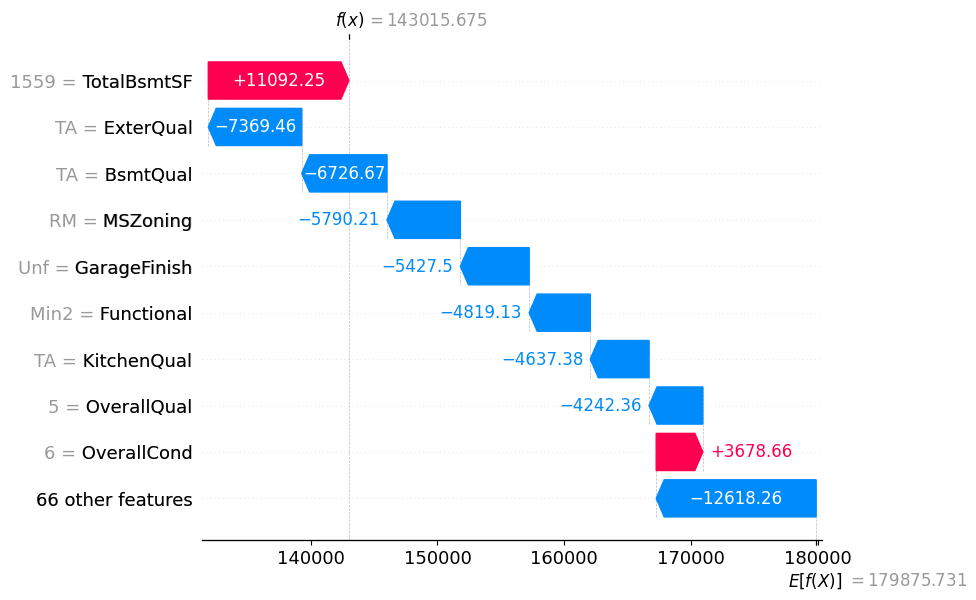

In [24]:
print(shap_values[0])
shap.plots.waterfall(shap_values[1])

In [ ]:
# Select only the chosen features which are most important according to the former calculations
df_train = df_train_cleaned[features_numeric + features_categorical + ["SalePrice"]]

In [27]:
# Save the cleaned and modified DataFrame to use it in another notebook
%store df_train

Stored 'df_train' (DataFrame)
